In [ ]:
import cv2                                   # Import necessary libraries
import tensorflow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow
from deepface import DeepFace
from keras.models import load_model
from time import sleep
from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import random
import glob
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from PIL import Image

import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
!pip install opencv-python-headless


####  Facial Detection - Haar cascade classifier

In [ ]:
face_cap=cv2.CascadeClassifier("C:/Users/varun/OneDrive/Desktop/ml project/haarcascade_frontalface_default.xml")    # Haar Cascade Classifier

video_cap = cv2.VideoCapture(0)                # Opening the camera

while True:

    ret, data =video_cap.read()       # Reading frame by frame

    color_img=cv2.cvtColor(data,cv2.COLOR_BGR2GRAY)

    faces=face_cap.detectMultiScale(color_img,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)     # Detecting the faces

    for (x,y,w,h) in faces:                                            # Drawing a rectangle around each face
        cv2.rectangle(data, (x,y), (x+w,y+h), (0,255,0), 2)

    cv2.imshow("Face Detection", data)

    k=cv2.waitKey(1)                    # Closing the camera by pressing 'q'

    if k==ord('q'):
        break

video_cap.release()

#### Age and Gender using pre trained models - Using FaceNet, AgeNet and GenderNet

In [ ]:
def getfaceBox(net, frameDnn, conf_threshold=0.7):
    frameHeight = frameDnn.shape[0]
    frameWidth = frameDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameDnn, 1.0, (300, 300), [104, 117, 123], True, False)          # Read the image

    net.setInput(blob)                # Use FaceNet
    detections = net.forward()

    bboxes = []                                                       # Store all the face details
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]                            # Accuracy that a face is present
        if confidence > conf_threshold:                                # If a certain accuracy is achieved, we confirm that a face is present over that region
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameDnn, (x1, y1), (x2, y2), (0, 255, 0), 1)               # Drawing a boundary around the face
    return frameDnn, bboxes

# Using FaceNet, AgeNet, GenderNet pre-trained models

faceProto = "C:/Users/varun/OneDrive/Desktop/ml project/opencv_face_detector.pbtxt"
faceModel = "C:/Users/varun/OneDrive/Desktop/ml project/opencv_face_detector_uint8.pb"

ageProto = "C:/Users/varun/OneDrive/Desktop/ml project/age_deploy.prototxt"
ageModel = "C:/Users/varun/OneDrive/Desktop/ml project/age_net.caffemodel"

genderProto = "C:/Users/varun/OneDrive/Desktop/ml project/gender_deploy.prototxt"
genderModel = "C:/Users/varun/OneDrive/Desktop/ml project/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)
faceNet = cv2.dnn.readNet(faceModel, faceProto)

video = cv2.VideoCapture(0)                                # Opening the camera stream

while True:
    ret, frame = video.read()                             # Reading the video stream frame by frame

    frameFace, bboxes = getfaceBox(faceNet, frame)            # Detecting the faces

    for bbox in bboxes:
        face = frame[bbox[1]:bbox[3],bbox[0]:bbox[2]]                     # Using the coordinates

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

        genderNet.setInput(blob)                                 # Predicting the gender
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]

        ageNet.setInput(blob)                                   # Predicting the age
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        label = "{},{}".format(gender, age)

        cv2.rectangle(frameFace, (bbox[0], bbox[1]-30), (bbox[2], bbox[1]), (0, 255, 0), -1)          # Drawing the boundary box

        # Printing the predictions on the screen for each individual

        cv2.putText(frameFace, label, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow("Age-Gender", frameFace)

    k=cv2.waitKey(1)                              # Exit by pressing 'q' key
    if k==ord('q'):
        break

video.release()                              # Closing the camera
cv2.destroyAllWindows()

#### Pre trained model for predictions (Age, Gender, Emotion)- DeepFace, FaceNet - for detecting faces

In [ ]:
def getfaceBox(net, frameDnn, conf_threshold=0.7):

    frameHeight = frameDnn.shape[0]
    frameWidth = frameDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameDnn, 1.0, (300, 300), [104, 117, 123], True, False)           # Read the image

    net.setInput(blob)                                        # Use FaceNet
    detections = net.forward()

    bboxes = []                                                         # Store all the face details
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]                             # Accuracy that a face is present
        if confidence > conf_threshold:                                 # If a certain accuracy is achieved, we confirm that a face is present over that region
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameDnn, (x1, y1), (x2, y2), (0, 255, 0), 1)         # Drawing a boundary around the face
    return frameDnn, bboxes

video = cv2.VideoCapture(0)               # Opening the camera stream

while True:

    ret, frame = video.read()                            # Reading the video stream frame by frame

    frameFace, bboxes = getfaceBox(faceNet, frame)       # Detecting the faces

    for bbox in bboxes:

        face = frame[bbox[1]:bbox[3],bbox[0]:bbox[2]]                # Using the coordinates

        age=" "

        gender=" "

        emotion=" "

        try:                                                                              # Predicting the age, gender and facial emotion
            result = DeepFace.analyze(frame, actions = ['age','gender','emotion'])

            age=result[0]["age"]

            gender=result[0]["dominant_gender"]

            emotion=(result[0]["dominant_emotion"])

        except:
            print("No faces")

        cv2.rectangle(frame,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(0,255,255),2)      # Drawing the boundary box

        # Printing the predictions on the screen for each individual

        cv2.putText(frame, str(age)+" : "+str(gender)+" : "+str(emotion), (bbox[0]+20, bbox[1]-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow('Age, Gender and Emotion Predictor',frame)

    k=cv2.waitKey(1)                                # Exit by pressing 'q' key
    if k==ord('q'):
        break

video.release()                                        # Close the camera
cv2.destroyAllWindows()


In [ ]:
pip install facenet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.9 MB/s eta 0:00:00


#### Age and Gender using pre trained models - Using FaceNet, AgeNet and GenderNet, DeepFace for Emotion Prediction

In [ ]:
def getfaceBox(net, frameDnn, conf_threshold=0.7):

    frameHeight = frameDnn.shape[0]
    frameWidth = frameDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameDnn, 1.0, (300, 300), [104, 117, 123], True, False)           # Read the image

    net.setInput(blob)                                        # Use FaceNet
    detections = net.forward()

    bboxes = []                                                         # Store all the face details
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]                             # Accuracy that a face is present
        if confidence > conf_threshold:                                 # If a certain accuracy is achieved, we confirm that a face is present over that region
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameDnn, (x1, y1), (x2, y2), (0, 255, 0), 1)         # Drawing a boundary around the face
    return frameDnn, bboxes

# Using FaceNet, AgeNet, GenderNet pre-trained models

faceProto = "C:/Users/varun/OneDrive/Desktop/ml project/opencv_face_detector.pbtxt"
faceModel = "C:/Users/varun/OneDrive/Desktop/ml project/opencv_face_detector_uint8.pb"

ageProto = "C:/Users/varun/OneDrive/Desktop/ml project/age_deploy.prototxt"
ageModel = "C:/Users/varun/OneDrive/Desktop/ml project/age_net.caffemodel"

genderProto = "C:/Users/varun/OneDrive/Desktop/ml project/gender_deploy.prototxt"
genderModel = "C:/Users/varun/OneDrive/Desktop/ml project/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-4)', '(4-8)', '(8-12)', '(12-20)', '(20-32)', '(32-43)', '(43-60)', '(60-100)']
genderList = ['Male', 'Female']

ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)
faceNet = cv2.dnn.readNet(faceModel, faceProto)

video = cv2.VideoCapture(0)                     # Opening the camera stream

while True:

    ret, frame = video.read()              # Reading the video stream frame by frame

    frameFace, bboxes = getfaceBox(faceNet, frame)          # Detecting the faces

    for bbox in bboxes:

        face = frame[bbox[1]:bbox[3],bbox[0]:bbox[2]]       # Using the coordinates

        try:                                                             # Analyzing the facial expression
            result = DeepFace.analyze(frame, actions = ['emotion'])
        except:
            print("No faces")

        print(result)

        label=(result[0]["dominant_emotion"])                     # Taking the dominant one

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

        genderNet.setInput(blob)                                    # Pass through the GenderNet
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]                # Predicting the gender

        ageNet.setInput(blob)                                       # Pass through AgeNet
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]                         # Predicting the age

        cv2.rectangle(frame,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(0,255,255),2)      # Drawing the boundary box

        # Printing the predictions on the screen for each individual

        cv2.putText(frame, age + " : " + gender + " : " + str(label), (bbox[0]-20, bbox[1]-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow('Age, Gender and Emotion Predictor',frame)

    k=cv2.waitKey(1)                                # Exit by pressing 'q' key
    if k==ord('q'):
        break

video.release()                                        # Close the camera
cv2.destroyAllWindows()


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


[{'emotion': {'angry': 13.192592561244965, 'disgust': 1.0129255019388633e-11, 'fear': 0.020261821919120848, 'happy': 0.09949799859896302, 'sad': 0.5499022081494331, 'surprise': 0.007994946645339951, 'neutral': 86.12974882125854}, 'dominant_emotion': 'neutral', 'region': {'x': 274, 'y': 244, 'w': 147, 'h': 147}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


[{'emotion': {'angry': 37.722088370074225, 'disgust': 2.2950930952295227e-11, 'fear': 0.07240397108932184, 'happy': 0.33213713437919207, 'sad': 0.7218889031542655, 'surprise': 0.0265557316372789, 'neutral': 61.124919518837984}, 'dominant_emotion': 'neutral', 'region': {'x': 275, 'y': 244, 'w': 147, 'h': 147}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


[{'emotion': {'angry': 12.996748089790344, 'disgust': 1.757752336696214e-11, 'fear': 0.08520016563124955, 'happy': 0.14080448308959603, 'sad': 0.42346902191638947, 'surprise': 0.44454168528318405, 'neutral': 85.90923547744751}, 'dominant_emotion': 'neutral', 'region': {'x': 277, 'y': 245, 'w': 144, 'h': 144}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]

[{'emotion': {'angry': 0.7890389300882816, 'disgust': 7.80278545378985e-14, 'fear': 0.002781659168249462, 'happy': 0.015362462727352977, 'sad': 0.37898903246968985, 'surprise': 0.001123230867960956, 'neutral': 98.8127052783966}, 'dominant_emotion': 'neutral', 'region': {'x': 273, 'y': 244, 'w': 149, 'h': 149}}]



Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


[{'emotion': {'angry': 0.31557298767691705, 'disgust': 7.412373631900866e-15, 'fear': 0.0013377232565636066, 'happy': 0.011026697616481496, 'sad': 0.057480741392387916, 'surprise': 0.0024569252873644577, 'neutral': 99.61212272788558}, 'dominant_emotion': 'neutral', 'region': {'x': 276, 'y': 245, 'w': 143, 'h': 143}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]


[{'emotion': {'angry': 93.45434269036905, 'disgust': 3.4542286456273757e-10, 'fear': 0.04583254031211378, 'happy': 0.051644139043264925, 'sad': 0.6048251303926188, 'surprise': 0.0018001418702388923, 'neutral': 5.841558029744507}, 'dominant_emotion': 'angry', 'region': {'x': 276, 'y': 246, 'w': 145, 'h': 145}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s]


[{'emotion': {'angry': 0.7459544576704502, 'disgust': 1.6365143732563053e-14, 'fear': 0.0015691504813730717, 'happy': 0.005648804290103726, 'sad': 0.07335463305935264, 'surprise': 0.010313971142750233, 'neutral': 99.163156747818}, 'dominant_emotion': 'neutral', 'region': {'x': 278, 'y': 245, 'w': 144, 'h': 144}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.29it/s]


[{'emotion': {'angry': 15.69397747516632, 'disgust': 1.1668380020882219e-10, 'fear': 0.07320723379962146, 'happy': 0.09547090157866478, 'sad': 0.4033127333968878, 'surprise': 0.10190469911321998, 'neutral': 83.63212943077087}, 'dominant_emotion': 'neutral', 'region': {'x': 282, 'y': 244, 'w': 146, 'h': 146}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


[{'emotion': {'angry': 26.04614794254303, 'disgust': 5.715256826827053e-11, 'fear': 0.01969031000044197, 'happy': 0.01929092832142487, 'sad': 0.9053039364516735, 'surprise': 0.004067376721650362, 'neutral': 73.0055034160614}, 'dominant_emotion': 'neutral', 'region': {'x': 299, 'y': 236, 'w': 146, 'h': 146}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s]

[{'emotion': {'angry': 3.217906877398491, 'disgust': 8.718427997773948e-11, 'fear': 0.014033625484444201, 'happy': 0.03771347401198, 'sad': 0.4658577963709831, 'surprise': 0.007136721251299605, 'neutral': 96.25735282897949}, 'dominant_emotion': 'neutral', 'region': {'x': 313, 'y': 222, 'w': 156, 'h': 156}}]



Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


[{'emotion': {'angry': 37.60335147380829, 'disgust': 3.4639487722643025e-06, 'fear': 0.05116925458423793, 'happy': 1.0586238466203213, 'sad': 2.5546079501509666, 'surprise': 0.04975430201739073, 'neutral': 58.6824893951416}, 'dominant_emotion': 'neutral', 'region': {'x': 352, 'y': 204, 'w': 163, 'h': 163}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.53it/s]


[{'emotion': {'angry': 7.739678770303726, 'disgust': 1.1756974949150845e-06, 'fear': 1.7317529767751694, 'happy': 0.256866542622447, 'sad': 2.346160262823105, 'surprise': 0.16962651861831546, 'neutral': 87.75591254234314}, 'dominant_emotion': 'neutral', 'region': {'x': 374, 'y': 198, 'w': 166, 'h': 166}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


[{'emotion': {'angry': 0.41768033988773823, 'disgust': 7.027112225443943e-09, 'fear': 0.05683641065843403, 'happy': 0.18877710681408644, 'sad': 1.033502072095871, 'surprise': 0.004237327448208816, 'neutral': 98.29896688461304}, 'dominant_emotion': 'neutral', 'region': {'x': 382, 'y': 188, 'w': 178, 'h': 178}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


[{'emotion': {'angry': 96.25933214910839, 'disgust': 0.00010147521079437971, 'fear': 1.341580346485335, 'happy': 0.5972803789639021, 'sad': 1.2690893724156174, 'surprise': 0.0012113695822548525, 'neutral': 0.5314038898612392}, 'dominant_emotion': 'angry', 'region': {'x': 371, 'y': 189, 'w': 178, 'h': 178}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


[{'emotion': {'angry': 19.607891142368317, 'disgust': 1.9306166387789148e-08, 'fear': 0.09620671044103801, 'happy': 3.6942608654499054, 'sad': 0.9637200273573399, 'surprise': 0.04504183307290077, 'neutral': 75.59288144111633}, 'dominant_emotion': 'neutral', 'region': {'x': 344, 'y': 195, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.79it/s]


[{'emotion': {'angry': 32.57524163427849, 'disgust': 8.489751256014865e-11, 'fear': 0.09914368874429927, 'happy': 1.0637351648491817, 'sad': 0.05004545106163037, 'surprise': 0.9044896026837352, 'neutral': 65.30735079137692}, 'dominant_emotion': 'neutral', 'region': {'x': 312, 'y': 196, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


[{'emotion': {'angry': 0.007221477426355705, 'disgust': 2.748667408773895e-16, 'fear': 0.00024506316549377516, 'happy': 0.0005364251137507381, 'sad': 0.02293665602337569, 'surprise': 0.00015986762491593254, 'neutral': 99.9688982963562}, 'dominant_emotion': 'neutral', 'region': {'x': 301, 'y': 199, 'w': 167, 'h': 167}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


[{'emotion': {'angry': 0.06841760244457692, 'disgust': 3.5633901572509914e-14, 'fear': 0.010776392616677791, 'happy': 0.23097064852319377, 'sad': 0.041838002758785756, 'surprise': 0.00032504108948725325, 'neutral': 99.64767102626908}, 'dominant_emotion': 'neutral', 'region': {'x': 287, 'y': 199, 'w': 175, 'h': 175}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s]


[{'emotion': {'angry': 0.05165343754924834, 'disgust': 1.3085618243345002e-13, 'fear': 0.1076726708561182, 'happy': 0.7878612726926804, 'sad': 0.2000443870201707, 'surprise': 0.024952637613750994, 'neutral': 98.82782101631165}, 'dominant_emotion': 'neutral', 'region': {'x': 290, 'y': 201, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


[{'emotion': {'angry': 0.00583360527832855, 'disgust': 3.674756929525964e-17, 'fear': 0.0001175662506196717, 'happy': 0.00040741615211950386, 'sad': 0.011674372280882996, 'surprise': 6.399248865125312e-05, 'neutral': 99.98189807153963}, 'dominant_emotion': 'neutral', 'region': {'x': 294, 'y': 200, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s]


[{'emotion': {'angry': 33.23683440685272, 'disgust': 2.117658652600607e-09, 'fear': 3.317146748304367, 'happy': 10.581722110509872, 'sad': 0.2740568248555064, 'surprise': 18.253830075263977, 'neutral': 34.33640897274017}, 'dominant_emotion': 'neutral', 'region': {'x': 304, 'y': 201, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


[{'emotion': {'angry': 8.705464005470276, 'disgust': 4.766799802102817e-10, 'fear': 1.4722974970936775, 'happy': 7.406198978424072, 'sad': 0.37809833884239197, 'surprise': 1.164488773792982, 'neutral': 80.87345361709595}, 'dominant_emotion': 'neutral', 'region': {'x': 309, 'y': 202, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


[{'emotion': {'angry': 0.010069742584101414, 'disgust': 5.926167265836978e-13, 'fear': 0.017154581586730874, 'happy': 0.17426488795592712, 'sad': 0.05588369427859451, 'surprise': 0.030530845470702377, 'neutral': 99.71209762764559}, 'dominant_emotion': 'neutral', 'region': {'x': 315, 'y': 200, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


[{'emotion': {'angry': 0.07529678854066363, 'disgust': 2.3026462871067837e-13, 'fear': 0.005193694906096415, 'happy': 0.04788195941545573, 'sad': 0.06324065993298053, 'surprise': 0.013949801463435678, 'neutral': 99.79443548884603}, 'dominant_emotion': 'neutral', 'region': {'x': 315, 'y': 200, 'w': 175, 'h': 175}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s]


[{'emotion': {'angry': 0.2658466808497906, 'disgust': 5.366469352162634e-14, 'fear': 0.008215056004701182, 'happy': 0.11214851401746273, 'sad': 0.10953021701425314, 'surprise': 0.010823438060469925, 'neutral': 99.49343800544739}, 'dominant_emotion': 'neutral', 'region': {'x': 317, 'y': 200, 'w': 175, 'h': 175}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


[{'emotion': {'angry': 0.0017137195754912682, 'disgust': 2.2474768144716373e-16, 'fear': 0.00017857126977105509, 'happy': 0.0010059796295536216, 'sad': 0.02040600957116112, 'surprise': 5.578229433922388e-05, 'neutral': 99.97664093971252}, 'dominant_emotion': 'neutral', 'region': {'x': 318, 'y': 201, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


[{'emotion': {'angry': 1.7516807765770421, 'disgust': 1.34815699632099e-09, 'fear': 0.5150673752318248, 'happy': 1.8069430400099182, 'sad': 0.24900416930789765, 'surprise': 0.846686730336352, 'neutral': 94.83061998072982}, 'dominant_emotion': 'neutral', 'region': {'x': 319, 'y': 202, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.18it/s]


[{'emotion': {'angry': 0.0013336390906273404, 'disgust': 1.0405725600121282e-14, 'fear': 0.000948978378976105, 'happy': 0.008495979779393138, 'sad': 0.08664526911014432, 'surprise': 0.00022741925468303478, 'neutral': 99.90234970464407}, 'dominant_emotion': 'neutral', 'region': {'x': 321, 'y': 201, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


[{'emotion': {'angry': 0.04201280785614597, 'disgust': 1.51626159315754e-14, 'fear': 0.0010074811744073362, 'happy': 0.0018814257812674623, 'sad': 0.04062641770587371, 'surprise': 0.00026150457155196236, 'neutral': 99.91421102966136}, 'dominant_emotion': 'neutral', 'region': {'x': 322, 'y': 202, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 13.63it/s]


[{'emotion': {'angry': 0.003342739728395827, 'disgust': 7.832514490441128e-16, 'fear': 0.00024348453280254034, 'happy': 0.0010106070476467721, 'sad': 0.02241932088509202, 'surprise': 2.488525581156864e-05, 'neutral': 99.9729573726654}, 'dominant_emotion': 'neutral', 'region': {'x': 325, 'y': 203, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


[{'emotion': {'angry': 0.0009585103387661852, 'disgust': 1.28461183256148e-14, 'fear': 0.0007818732694803172, 'happy': 0.0013946137109063822, 'sad': 0.010530344925534051, 'surprise': 0.00013332056254266388, 'neutral': 99.98620152391204}, 'dominant_emotion': 'neutral', 'region': {'x': 323, 'y': 202, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


[{'emotion': {'angry': 0.06922651494899482, 'disgust': 1.3886595237072635e-12, 'fear': 0.01835221155736739, 'happy': 0.026763342751985355, 'sad': 0.07062686911795253, 'surprise': 0.007133601018274636, 'neutral': 99.80790017890335}, 'dominant_emotion': 'neutral', 'region': {'x': 319, 'y': 202, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


[{'emotion': {'angry': 1.5627235174179077, 'disgust': 9.613458033103095e-12, 'fear': 0.028702671988867223, 'happy': 0.09064403711818159, 'sad': 0.20288291852921247, 'surprise': 0.015274038014467806, 'neutral': 98.09977412223816}, 'dominant_emotion': 'neutral', 'region': {'x': 315, 'y': 202, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


[{'emotion': {'angry': 0.0002814922481775284, 'disgust': 6.5020977951779695e-18, 'fear': 4.8934634833130985e-05, 'happy': 0.0006486660822702106, 'sad': 0.0058430687204236165, 'surprise': 5.8000694025395205e-05, 'neutral': 99.99312162399292}, 'dominant_emotion': 'neutral', 'region': {'x': 313, 'y': 202, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.62it/s]


[{'emotion': {'angry': 0.0012357856012596218, 'disgust': 4.200729368349446e-15, 'fear': 0.00044466650407837006, 'happy': 0.002327735905872941, 'sad': 0.01537468159295689, 'surprise': 0.0002165329957448077, 'neutral': 99.98039603467035}, 'dominant_emotion': 'neutral', 'region': {'x': 314, 'y': 204, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


[{'emotion': {'angry': 0.0010846444638445973, 'disgust': 2.3052256017564144e-16, 'fear': 0.00047852713578322437, 'happy': 0.0015758532754261978, 'sad': 0.020809231500606984, 'surprise': 0.0006766332717234036, 'neutral': 99.97537732124329}, 'dominant_emotion': 'neutral', 'region': {'x': 313, 'y': 202, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


[{'emotion': {'angry': 0.00042361861640116395, 'disgust': 1.3738870285121948e-15, 'fear': 0.0006057146680248179, 'happy': 0.00493364109692065, 'sad': 0.015342801260875016, 'surprise': 0.0012970123225368305, 'neutral': 99.97739196093178}, 'dominant_emotion': 'neutral', 'region': {'x': 314, 'y': 203, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


[{'emotion': {'angry': 1.6379487543368755e-05, 'disgust': 2.2091440830888383e-19, 'fear': 1.3704863839086062e-05, 'happy': 0.0005261194787451733, 'sad': 0.0026480356369044454, 'surprise': 4.2097445551824595e-05, 'neutral': 99.99675154666612}, 'dominant_emotion': 'neutral', 'region': {'x': 313, 'y': 202, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


[{'emotion': {'angry': 0.001146738986512562, 'disgust': 7.194824051230252e-15, 'fear': 0.0032612238760929032, 'happy': 0.0176647817030623, 'sad': 0.01794504719137583, 'surprise': 0.006030716403567512, 'neutral': 99.95394945693619}, 'dominant_emotion': 'neutral', 'region': {'x': 315, 'y': 203, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


[{'emotion': {'angry': 0.004040989369968884, 'disgust': 9.096034530477103e-16, 'fear': 0.000601771262154216, 'happy': 0.005261519982013851, 'sad': 0.029904721304774284, 'surprise': 0.0013726501492783427, 'neutral': 99.95881915092468}, 'dominant_emotion': 'neutral', 'region': {'x': 314, 'y': 202, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]


[{'emotion': {'angry': 0.03367495373822749, 'disgust': 2.8992468711746806e-14, 'fear': 0.0009600262274034321, 'happy': 0.02940543636213988, 'sad': 0.01704381575109437, 'surprise': 0.009828605834627524, 'neutral': 99.90909099578857}, 'dominant_emotion': 'neutral', 'region': {'x': 318, 'y': 203, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]


[{'emotion': {'angry': 0.08593198284572567, 'disgust': 6.73108256761588e-14, 'fear': 0.0065137187868766445, 'happy': 0.04686557536591436, 'sad': 0.14013851253527254, 'surprise': 0.0037494642206640726, 'neutral': 99.7168004850387}, 'dominant_emotion': 'neutral', 'region': {'x': 315, 'y': 203, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s]


[{'emotion': {'angry': 0.004478331538848579, 'disgust': 1.1316352763779164e-13, 'fear': 0.005431845784187317, 'happy': 0.032497220672667027, 'sad': 0.014798315532971174, 'surprise': 0.014224318147171289, 'neutral': 99.92857575416565}, 'dominant_emotion': 'neutral', 'region': {'x': 317, 'y': 202, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s]


[{'emotion': {'angry': 0.19254733342677355, 'disgust': 1.1192886065013825e-13, 'fear': 0.0035551496694097295, 'happy': 0.02759578637778759, 'sad': 0.07425102521665394, 'surprise': 0.0030040320780244656, 'neutral': 99.6990442276001}, 'dominant_emotion': 'neutral', 'region': {'x': 316, 'y': 201, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


[{'emotion': {'angry': 0.004609128882293589, 'disgust': 3.412070065072241e-15, 'fear': 0.0005381717528507579, 'happy': 0.004330887531978078, 'sad': 0.017927556473296136, 'surprise': 0.0002001617758651264, 'neutral': 99.97239708900452}, 'dominant_emotion': 'neutral', 'region': {'x': 318, 'y': 202, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.31it/s]


[{'emotion': {'angry': 7.869959346649607, 'disgust': 4.8222918118621344e-09, 'fear': 0.08624145925925429, 'happy': 0.039569279209183406, 'sad': 3.1365348033031704, 'surprise': 0.0008642324761588857, 'neutral': 88.86682920854265}, 'dominant_emotion': 'neutral', 'region': {'x': 320, 'y': 203, 'w': 167, 'h': 167}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s]


[{'emotion': {'angry': 0.11443813082207029, 'disgust': 4.6012431212096155e-14, 'fear': 0.0015601165634905548, 'happy': 0.003903411794284689, 'sad': 0.06771132869974247, 'surprise': 0.0004743507189114541, 'neutral': 99.81191157173583}, 'dominant_emotion': 'neutral', 'region': {'x': 318, 'y': 202, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


[{'emotion': {'angry': 0.9753920837769409, 'disgust': 1.8842625136216326e-11, 'fear': 0.04466675795396322, 'happy': 0.10322502282187071, 'sad': 0.2067012233121725, 'surprise': 0.035416580938433896, 'neutral': 98.63459484164777}, 'dominant_emotion': 'neutral', 'region': {'x': 321, 'y': 204, 'w': 167, 'h': 167}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


[{'emotion': {'angry': 0.5440983921289444, 'disgust': 3.1264019964474116e-12, 'fear': 0.009386682359036058, 'happy': 0.044373219134286046, 'sad': 0.09030950022861362, 'surprise': 0.012858810077887028, 'neutral': 99.29897785186768}, 'dominant_emotion': 'neutral', 'region': {'x': 320, 'y': 205, 'w': 166, 'h': 166}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.51it/s]


[{'emotion': {'angry': 0.23137639724471554, 'disgust': 3.975667620705751e-12, 'fear': 0.01493618272330211, 'happy': 0.010557092074913805, 'sad': 0.1714840051485005, 'surprise': 0.0007914844462636435, 'neutral': 99.57085249250248}, 'dominant_emotion': 'neutral', 'region': {'x': 318, 'y': 202, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


[{'emotion': {'angry': 0.11731560807675123, 'disgust': 3.497770674918614e-14, 'fear': 0.0014323887626233045, 'happy': 0.011033826740458608, 'sad': 0.02274470607517287, 'surprise': 0.003976327570853755, 'neutral': 99.84349608421326}, 'dominant_emotion': 'neutral', 'region': {'x': 320, 'y': 203, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.98it/s]


[{'emotion': {'angry': 0.030028074979782104, 'disgust': 1.0760961730593992e-13, 'fear': 0.0014933356396795716, 'happy': 0.009519165905658156, 'sad': 0.019720180716831237, 'surprise': 0.008025112038012594, 'neutral': 99.9312162399292}, 'dominant_emotion': 'neutral', 'region': {'x': 319, 'y': 203, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.96it/s]


[{'emotion': {'angry': 3.8859757117018527, 'disgust': 1.519039840214307e-11, 'fear': 0.03593444339912792, 'happy': 0.036956535061093275, 'sad': 0.45139452339080116, 'surprise': 0.002040263037734511, 'neutral': 95.5877003423989}, 'dominant_emotion': 'neutral', 'region': {'x': 318, 'y': 202, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.25it/s]


[{'emotion': {'angry': 8.43011811375618, 'disgust': 3.419705382583238e-11, 'fear': 0.02659849706105888, 'happy': 0.106658018194139, 'sad': 0.22334083914756775, 'surprise': 0.013103400124236941, 'neutral': 91.20017886161804}, 'dominant_emotion': 'neutral', 'region': {'x': 320, 'y': 203, 'w': 167, 'h': 167}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s]


[{'emotion': {'angry': 0.0025316209468431946, 'disgust': 8.790263356751743e-15, 'fear': 0.0010002270472780224, 'happy': 0.005977595007156803, 'sad': 0.024613470280986097, 'surprise': 0.004705346676256159, 'neutral': 99.96116757855802}, 'dominant_emotion': 'neutral', 'region': {'x': 317, 'y': 203, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


[{'emotion': {'angry': 80.33486487477212, 'disgust': 1.7982048922564498e-06, 'fear': 4.663108567184721, 'happy': 5.760327697415811, 'sad': 0.4298568028126242, 'surprise': 0.35558228637768546, 'neutral': 8.45625525452228}, 'dominant_emotion': 'angry', 'region': {'x': 321, 'y': 207, 'w': 166, 'h': 166}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


[{'emotion': {'angry': 76.96331006069839, 'disgust': 3.8784150471436153e-05, 'fear': 7.764219210399342, 'happy': 5.989678561072264, 'sad': 2.4200828325797814, 'surprise': 0.20628223493887393, 'neutral': 6.656393060469214}, 'dominant_emotion': 'angry', 'region': {'x': 333, 'y': 207, 'w': 166, 'h': 166}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.53it/s]


[{'emotion': {'angry': 81.95436977796194, 'disgust': 8.146059798571093e-08, 'fear': 0.9210850278836522, 'happy': 0.9547850323957243, 'sad': 0.5873145770060512, 'surprise': 0.086774920213213, 'neutral': 15.495677649459559}, 'dominant_emotion': 'angry', 'region': {'x': 342, 'y': 207, 'w': 168, 'h': 168}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


[{'emotion': {'angry': 88.04798579788039, 'disgust': 2.3254917210755146e-06, 'fear': 2.989274805995799, 'happy': 1.0394077124485628, 'sad': 1.229677402785707, 'surprise': 0.015379816264488252, 'neutral': 6.678275069984802}, 'dominant_emotion': 'angry', 'region': {'x': 347, 'y': 208, 'w': 166, 'h': 166}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s]


[{'emotion': {'angry': 0.004073775926372036, 'disgust': 2.2721046179455435e-17, 'fear': 5.379081926548679e-05, 'happy': 0.0007354103217949159, 'sad': 0.00930618480197154, 'surprise': 1.8431640214089384e-06, 'neutral': 99.98582601547241}, 'dominant_emotion': 'neutral', 'region': {'x': 344, 'y': 207, 'w': 167, 'h': 167}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.54it/s]


[{'emotion': {'angry': 8.032076060771942, 'disgust': 5.363554245923011e-12, 'fear': 0.013566394045483321, 'happy': 0.00887185160536319, 'sad': 0.2482985844835639, 'surprise': 0.0007945713150547817, 'neutral': 91.69639348983765}, 'dominant_emotion': 'neutral', 'region': {'x': 337, 'y': 206, 'w': 168, 'h': 168}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]


[{'emotion': {'angry': 7.840850204229355, 'disgust': 4.875301009253652e-11, 'fear': 0.007150282908696681, 'happy': 0.05628471844829619, 'sad': 0.04852973506785929, 'surprise': 0.08579394198022783, 'neutral': 91.96139574050903}, 'dominant_emotion': 'neutral', 'region': {'x': 316, 'y': 206, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.54it/s]


[{'emotion': {'angry': 4.090089191777224e-05, 'disgust': 1.7249531287740604e-16, 'fear': 0.00016793404711279436, 'happy': 0.005563609374803491, 'sad': 0.008958950638771057, 'surprise': 4.334715981713089e-05, 'neutral': 99.98522996902466}, 'dominant_emotion': 'neutral', 'region': {'x': 298, 'y': 207, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


[{'emotion': {'angry': 0.0013529675925383344, 'disgust': 4.809601967020177e-15, 'fear': 0.0002887080881919246, 'happy': 0.0008857506145432126, 'sad': 0.06403589504770935, 'surprise': 2.5645223900028213e-05, 'neutral': 99.93341565132141}, 'dominant_emotion': 'neutral', 'region': {'x': 294, 'y': 207, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


[{'emotion': {'angry': 0.0009382140537916678, 'disgust': 9.736430856721977e-13, 'fear': 0.01696942300632882, 'happy': 0.11644287263261513, 'sad': 0.0183292748272173, 'surprise': 0.001366321511835164, 'neutral': 99.84595178639601}, 'dominant_emotion': 'neutral', 'region': {'x': 292, 'y': 203, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


[{'emotion': {'angry': 0.005415545902154525, 'disgust': 4.785017721145436e-14, 'fear': 0.003101051691864043, 'happy': 0.017447336825300832, 'sad': 0.07988962673035244, 'surprise': 0.00018322265394512242, 'neutral': 99.89395738912137}, 'dominant_emotion': 'neutral', 'region': {'x': 291, 'y': 201, 'w': 176, 'h': 176}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]


[{'emotion': {'angry': 0.01974257874630861, 'disgust': 6.446758219641863e-15, 'fear': 0.0009903547515058462, 'happy': 0.008908128605801827, 'sad': 0.058397229283510405, 'surprise': 7.217606569623116e-05, 'neutral': 99.9118924088414}, 'dominant_emotion': 'neutral', 'region': {'x': 289, 'y': 199, 'w': 178, 'h': 178}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


[{'emotion': {'angry': 0.12216111352981764, 'disgust': 4.67008701060686e-14, 'fear': 0.0048125084224147, 'happy': 0.015655824561654083, 'sad': 0.034534662221151625, 'surprise': 0.0039985314978407405, 'neutral': 99.81883170380215}, 'dominant_emotion': 'neutral', 'region': {'x': 288, 'y': 200, 'w': 178, 'h': 178}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.60it/s]


[{'emotion': {'angry': 0.14908101875334978, 'disgust': 1.4643099016317662e-13, 'fear': 0.03619431518018246, 'happy': 0.0584547349717468, 'sad': 0.12833363143727183, 'surprise': 0.013031221169512719, 'neutral': 99.61490631103516}, 'dominant_emotion': 'neutral', 'region': {'x': 286, 'y': 199, 'w': 178, 'h': 178}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


[{'emotion': {'angry': 1.3483701273798943, 'disgust': 2.479805369295235e-11, 'fear': 1.016764622181654, 'happy': 0.6459193304181099, 'sad': 0.7623258512467146, 'surprise': 0.05437176441773772, 'neutral': 96.17224931716919}, 'dominant_emotion': 'neutral', 'region': {'x': 287, 'y': 199, 'w': 178, 'h': 178}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s]


[{'emotion': {'angry': 0.010147139132643961, 'disgust': 2.3657037711202123e-15, 'fear': 0.003947034436962757, 'happy': 0.009763397101645744, 'sad': 0.03376970909187699, 'surprise': 0.004887528048410821, 'neutral': 99.93748664483348}, 'dominant_emotion': 'neutral', 'region': {'x': 294, 'y': 202, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


[{'emotion': {'angry': 0.05737892832187673, 'disgust': 6.8631226799049025e-15, 'fear': 0.009150497863289224, 'happy': 0.015284122124903246, 'sad': 0.14207617548690135, 'surprise': 0.00083486001183085, 'neutral': 99.77527263459294}, 'dominant_emotion': 'neutral', 'region': {'x': 294, 'y': 198, 'w': 177, 'h': 177}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


[{'emotion': {'angry': 0.006458946882048622, 'disgust': 5.2935565575396365e-15, 'fear': 0.003068466321565211, 'happy': 0.003939534144592471, 'sad': 0.035583681892603636, 'surprise': 0.001016257556329947, 'neutral': 99.94993209838867}, 'dominant_emotion': 'neutral', 'region': {'x': 298, 'y': 202, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.14it/s]


[{'emotion': {'angry': 0.3957709291403378, 'disgust': 4.605039652572308e-14, 'fear': 0.005191211420949491, 'happy': 0.01454248821927375, 'sad': 0.08295528416682373, 'surprise': 0.0020246575646743472, 'neutral': 99.49951177841284}, 'dominant_emotion': 'neutral', 'region': {'x': 298, 'y': 201, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


[{'emotion': {'angry': 5.6340135633945465, 'disgust': 3.0109236230559805e-12, 'fear': 0.022532361617777497, 'happy': 0.16174999764189124, 'sad': 0.19431159598752856, 'surprise': 0.006196281174197793, 'neutral': 93.98119449615479}, 'dominant_emotion': 'neutral', 'region': {'x': 299, 'y': 202, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s]


[{'emotion': {'angry': 0.0029860260838177055, 'disgust': 3.7240584384533564e-15, 'fear': 0.0029961525797261856, 'happy': 0.006481281889136881, 'sad': 0.04641707055270672, 'surprise': 0.004094645555596799, 'neutral': 99.9370276927948}, 'dominant_emotion': 'neutral', 'region': {'x': 301, 'y': 203, 'w': 167, 'h': 167}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


[{'emotion': {'angry': 0.3213954856619239, 'disgust': 1.1895928705190815e-13, 'fear': 0.008523319411324337, 'happy': 0.014912954065948725, 'sad': 0.1504204818047583, 'surprise': 0.009260714432457462, 'neutral': 99.49548840522766}, 'dominant_emotion': 'neutral', 'region': {'x': 302, 'y': 204, 'w': 167, 'h': 167}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


[{'emotion': {'angry': 0.007567183638457209, 'disgust': 5.415095528431033e-15, 'fear': 0.0013342270904104225, 'happy': 0.0035149281757185236, 'sad': 0.03394937375560403, 'surprise': 0.0022827904103905894, 'neutral': 99.95135068893433}, 'dominant_emotion': 'neutral', 'region': {'x': 302, 'y': 203, 'w': 166, 'h': 166}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s]


[{'emotion': {'angry': 0.002225535354227759, 'disgust': 1.9457567717015407e-15, 'fear': 0.0027645985028357245, 'happy': 0.007981768430909142, 'sad': 0.026937443180941045, 'surprise': 0.007500680658267811, 'neutral': 99.95259046554565}, 'dominant_emotion': 'neutral', 'region': {'x': 302, 'y': 202, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


[{'emotion': {'angry': 1.304645650088787, 'disgust': 1.4390952554513108e-12, 'fear': 0.06777720409445465, 'happy': 0.21249884739518166, 'sad': 0.29966982547193766, 'surprise': 0.02130152133759111, 'neutral': 98.0941116809845}, 'dominant_emotion': 'neutral', 'region': {'x': 299, 'y': 201, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


[{'emotion': {'angry': 0.05338264163583517, 'disgust': 9.683684978894577e-15, 'fear': 0.0039627975638723, 'happy': 0.016903494542930275, 'sad': 0.059740355936810374, 'surprise': 0.006615073652938008, 'neutral': 99.85939860343933}, 'dominant_emotion': 'neutral', 'region': {'x': 299, 'y': 201, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


[{'emotion': {'angry': 0.08457570376276032, 'disgust': 5.0888362270089486e-14, 'fear': 0.012456958909061979, 'happy': 0.028207039124797093, 'sad': 0.12374401247200222, 'surprise': 0.0008200324305259612, 'neutral': 99.75019100306142}, 'dominant_emotion': 'neutral', 'region': {'x': 297, 'y': 201, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]


[{'emotion': {'angry': 2.6122528448406275, 'disgust': 8.759939999038341e-10, 'fear': 1.9708570579716036, 'happy': 0.38503080074111234, 'sad': 1.0449726448920542, 'surprise': 0.07526465075451443, 'neutral': 93.91162322898188}, 'dominant_emotion': 'neutral', 'region': {'x': 293, 'y': 198, 'w': 179, 'h': 179}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


[{'emotion': {'angry': 0.0529992913045834, 'disgust': 1.0539433168173376e-14, 'fear': 0.006561089630872502, 'happy': 0.007961079751590073, 'sad': 0.09275152173620203, 'surprise': 0.0010136707416096655, 'neutral': 99.83870985046508}, 'dominant_emotion': 'neutral', 'region': {'x': 297, 'y': 203, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s]


[{'emotion': {'angry': 0.0018765319718844688, 'disgust': 3.712013338344657e-16, 'fear': 0.00014077587295640805, 'happy': 0.000783159567913704, 'sad': 0.020853774700911324, 'surprise': 9.423883391358342e-05, 'neutral': 99.97625350810608}, 'dominant_emotion': 'neutral', 'region': {'x': 297, 'y': 201, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


[{'emotion': {'angry': 0.3373023651775878, 'disgust': 7.459367655714765e-13, 'fear': 0.02080575838858534, 'happy': 0.025771508646427556, 'sad': 0.19212714434389538, 'surprise': 0.019707307198517657, 'neutral': 99.40428144880754}, 'dominant_emotion': 'neutral', 'region': {'x': 299, 'y': 202, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]


[{'emotion': {'angry': 0.014756247401237488, 'disgust': 4.056606749918947e-14, 'fear': 0.009552478149998933, 'happy': 0.01614025968592614, 'sad': 0.037131464341655374, 'surprise': 0.02053939097095281, 'neutral': 99.90187883377075}, 'dominant_emotion': 'neutral', 'region': {'x': 300, 'y': 202, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


[{'emotion': {'angry': 1.3186657801270485, 'disgust': 1.3605755553507213e-12, 'fear': 0.03454327816143632, 'happy': 0.01877634203992784, 'sad': 0.2849444281309843, 'surprise': 0.002636130739119835, 'neutral': 98.34043383598328}, 'dominant_emotion': 'neutral', 'region': {'x': 296, 'y': 199, 'w': 175, 'h': 175}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


[{'emotion': {'angry': 0.001620227800397742, 'disgust': 1.482131453168894e-16, 'fear': 9.216766992749437e-05, 'happy': 0.0016461225712921885, 'sad': 0.009600983166101317, 'surprise': 0.00033639921370764465, 'neutral': 99.986702202958}, 'dominant_emotion': 'neutral', 'region': {'x': 297, 'y': 200, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s]


[{'emotion': {'angry': 0.0002631548568388098, 'disgust': 3.373936077236084e-17, 'fear': 0.00019486160454107448, 'happy': 0.002020120882662013, 'sad': 0.004918760168948211, 'surprise': 0.00037406484807434026, 'neutral': 99.99222755432129}, 'dominant_emotion': 'neutral', 'region': {'x': 297, 'y': 199, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


[{'emotion': {'angry': 0.008180077566066757, 'disgust': 9.285452571091866e-14, 'fear': 0.09876260301098228, 'happy': 0.2866551047191024, 'sad': 0.06823362782597542, 'surprise': 0.0011032913789676968, 'neutral': 99.53706860542297}, 'dominant_emotion': 'neutral', 'region': {'x': 295, 'y': 197, 'w': 178, 'h': 178}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


[{'emotion': {'angry': 0.0014532233719714413, 'disgust': 5.958655868283711e-17, 'fear': 0.0004109486571286936, 'happy': 0.0008494460923150647, 'sad': 0.012760570858769617, 'surprise': 0.00019875118416653786, 'neutral': 99.98432993795454}, 'dominant_emotion': 'neutral', 'region': {'x': 295, 'y': 199, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


[{'emotion': {'angry': 0.00042310832916776005, 'disgust': 4.0830219080656355e-17, 'fear': 0.0005500445568465876, 'happy': 0.002792520520425228, 'sad': 0.008937514017569736, 'surprise': 0.00159634337671192, 'neutral': 99.98570084486609}, 'dominant_emotion': 'neutral', 'region': {'x': 295, 'y': 198, 'w': 175, 'h': 175}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


[{'emotion': {'angry': 0.00012708226981255643, 'disgust': 1.7398803050932412e-19, 'fear': 1.5146782643278953e-05, 'happy': 0.0008392567815434951, 'sad': 0.002222705469344463, 'surprise': 7.029348993136563e-05, 'neutral': 99.99672174492815}, 'dominant_emotion': 'neutral', 'region': {'x': 294, 'y': 197, 'w': 177, 'h': 177}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


[{'emotion': {'angry': 1.4507046900689602, 'disgust': 6.267212443455961e-10, 'fear': 2.450792118906975, 'happy': 0.8050736039876938, 'sad': 0.9889296256005764, 'surprise': 0.03498090663924813, 'neutral': 94.26952004432678}, 'dominant_emotion': 'neutral', 'region': {'x': 295, 'y': 200, 'w': 175, 'h': 175}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


[{'emotion': {'angry': 0.3778305828395833, 'disgust': 8.68829208181329e-15, 'fear': 0.008756747933041181, 'happy': 0.0036710544378240444, 'sad': 0.06056001654438773, 'surprise': 0.0004259104825109438, 'neutral': 99.54875704936725}, 'dominant_emotion': 'neutral', 'region': {'x': 295, 'y': 201, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


[{'emotion': {'angry': 0.0006901239387188639, 'disgust': 2.4306926053466035e-17, 'fear': 8.456247477796418e-05, 'happy': 0.001632953814821359, 'sad': 0.005106303373983517, 'surprise': 0.00026728286458514944, 'neutral': 99.99222159339318}, 'dominant_emotion': 'neutral', 'region': {'x': 295, 'y': 199, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


[{'emotion': {'angry': 0.166609778534621, 'disgust': 9.537868812890121e-13, 'fear': 0.11527086608111858, 'happy': 0.04625075380317867, 'sad': 0.1498095691204071, 'surprise': 0.0021235502572380938, 'neutral': 99.51993823051453}, 'dominant_emotion': 'neutral', 'region': {'x': 295, 'y': 200, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.74it/s]


[{'emotion': {'angry': 0.0027438427790539566, 'disgust': 1.7248742892960412e-17, 'fear': 0.0003306256364014522, 'happy': 0.0002798505768800398, 'sad': 0.014008732763475, 'surprise': 2.4384837551070242e-05, 'neutral': 99.98261332719167}, 'dominant_emotion': 'neutral', 'region': {'x': 297, 'y': 202, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


[{'emotion': {'angry': 0.002032447991950903, 'disgust': 6.611664975894007e-17, 'fear': 0.00029909015211160295, 'happy': 0.0022838006771053188, 'sad': 0.031074101570993662, 'surprise': 3.5159050781885526e-06, 'neutral': 99.9643087387085}, 'dominant_emotion': 'neutral', 'region': {'x': 295, 'y': 201, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]


[{'emotion': {'angry': 0.12009984347969294, 'disgust': 5.891691189348976e-14, 'fear': 0.009106710785999894, 'happy': 0.0031816431146580726, 'sad': 0.16307438490912318, 'surprise': 0.00019682879610627424, 'neutral': 99.70434308052063}, 'dominant_emotion': 'neutral', 'region': {'x': 297, 'y': 203, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


[{'emotion': {'angry': 0.0006285914878390031, 'disgust': 2.1223897092113618e-17, 'fear': 0.0001473998395340459, 'happy': 0.0004206742687529186, 'sad': 0.01133589685196057, 'surprise': 2.427528897896991e-05, 'neutral': 99.9874472618103}, 'dominant_emotion': 'neutral', 'region': {'x': 295, 'y': 202, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]

[{'emotion': {'angry': 0.0006427387617100316, 'disgust': 4.515711581982371e-17, 'fear': 0.00014035472004096566, 'happy': 0.0002510806247799517, 'sad': 0.013791331097153192, 'surprise': 1.9361276048458045e-05, 'neutral': 99.98515248210147}, 'dominant_emotion': 'neutral', 'region': {'x': 293, 'y': 202, 'w': 170, 'h': 170}}]



Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


[{'emotion': {'angry': 9.054436986843939e-05, 'disgust': 7.615880334109282e-18, 'fear': 7.726279136477388e-05, 'happy': 0.002511383718228899, 'sad': 0.002752124783000909, 'surprise': 6.514508754662529e-06, 'neutral': 99.99456405639648}, 'dominant_emotion': 'neutral', 'region': {'x': 290, 'y': 197, 'w': 178, 'h': 178}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]


[{'emotion': {'angry': 0.3183951135724783, 'disgust': 1.7546194328748634e-12, 'fear': 0.2274167723953724, 'happy': 0.16422049375250936, 'sad': 0.7021008059382439, 'surprise': 0.0005354507720767288, 'neutral': 98.58733415603638}, 'dominant_emotion': 'neutral', 'region': {'x': 291, 'y': 199, 'w': 176, 'h': 176}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


[{'emotion': {'angry': 0.000837971947476035, 'disgust': 8.164712731833656e-18, 'fear': 0.00015244950191117823, 'happy': 0.000180497636392829, 'sad': 0.004443685611477122, 'surprise': 4.189094227058376e-06, 'neutral': 99.99438524246216}, 'dominant_emotion': 'neutral', 'region': {'x': 292, 'y': 199, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


[{'emotion': {'angry': 0.00010394451237516478, 'disgust': 4.749894674538816e-18, 'fear': 2.755705850177037e-05, 'happy': 0.0008779361451161094, 'sad': 0.0038568523450521752, 'surprise': 4.4574983348866226e-05, 'neutral': 99.99508857727051}, 'dominant_emotion': 'neutral', 'region': {'x': 293, 'y': 200, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.91it/s]


[{'emotion': {'angry': 0.00018343745252582893, 'disgust': 2.9932039543679935e-18, 'fear': 3.838906310726601e-05, 'happy': 0.00028778760575773826, 'sad': 0.007211004115179427, 'surprise': 1.0624648461473009e-06, 'neutral': 99.99228119804151}, 'dominant_emotion': 'neutral', 'region': {'x': 291, 'y': 199, 'w': 175, 'h': 175}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


[{'emotion': {'angry': 0.0013479992048814893, 'disgust': 3.512370439613545e-17, 'fear': 6.349151249196439e-05, 'happy': 0.0009742061592987739, 'sad': 0.013343767204787582, 'surprise': 2.3162792217590322e-05, 'neutral': 99.98425245285034}, 'dominant_emotion': 'neutral', 'region': {'x': 291, 'y': 199, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


[{'emotion': {'angry': 9.70474049792733e-05, 'disgust': 2.7008577253114264e-16, 'fear': 0.000206391975600317, 'happy': 0.00779982239904559, 'sad': 0.004230337212428602, 'surprise': 7.0924877987877706e-06, 'neutral': 99.98766183706067}, 'dominant_emotion': 'neutral', 'region': {'x': 292, 'y': 198, 'w': 176, 'h': 176}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


[{'emotion': {'angry': 0.0002089816256481205, 'disgust': 7.050251969773753e-17, 'fear': 0.00040893442346701044, 'happy': 0.0022152203112940304, 'sad': 0.009560159790516321, 'surprise': 5.295727368431087e-05, 'neutral': 99.98755454868729}, 'dominant_emotion': 'neutral', 'region': {'x': 294, 'y': 201, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]


[{'emotion': {'angry': 0.00014313820314654498, 'disgust': 4.0813276389532933e-19, 'fear': 1.0754167473514608e-05, 'happy': 6.480523575723795e-05, 'sad': 0.003983973035986024, 'surprise': 3.254173653417252e-07, 'neutral': 99.9957919125805}, 'dominant_emotion': 'neutral', 'region': {'x': 291, 'y': 199, 'w': 175, 'h': 175}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


[{'emotion': {'angry': 0.0004279121640138328, 'disgust': 3.62885459508463e-18, 'fear': 3.8919114331292803e-05, 'happy': 0.00011829120012407657, 'sad': 0.009133559069596231, 'surprise': 6.684472086959659e-07, 'neutral': 99.99028444290161}, 'dominant_emotion': 'neutral', 'region': {'x': 293, 'y': 201, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.64it/s]


[{'emotion': {'angry': 0.012134911230532452, 'disgust': 1.874271492292463e-14, 'fear': 0.004379960591904819, 'happy': 0.006722395482938737, 'sad': 0.07272341754287481, 'surprise': 1.829532578767612e-05, 'neutral': 99.90401864051819}, 'dominant_emotion': 'neutral', 'region': {'x': 292, 'y': 200, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


[{'emotion': {'angry': 0.01110707235056907, 'disgust': 1.8083886608500927e-13, 'fear': 0.008274480205727741, 'happy': 0.008382834494113922, 'sad': 0.05392068414948881, 'surprise': 0.0012103228982596193, 'neutral': 99.91710186004639}, 'dominant_emotion': 'neutral', 'region': {'x': 292, 'y': 200, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


[{'emotion': {'angry': 0.0004396482381707756, 'disgust': 1.498999516221492e-17, 'fear': 7.047720487207698e-05, 'happy': 0.0002921232635344495, 'sad': 0.005727532698074356, 'surprise': 1.3686891620068309e-06, 'neutral': 99.99346733093262}, 'dominant_emotion': 'neutral', 'region': {'x': 292, 'y': 200, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


[{'emotion': {'angry': 0.1145063666626811, 'disgust': 1.169139565941732e-13, 'fear': 0.06496355636045337, 'happy': 0.05067706806585193, 'sad': 0.0543002097401768, 'surprise': 0.019223621347919106, 'neutral': 99.69633221626282}, 'dominant_emotion': 'neutral', 'region': {'x': 292, 'y': 200, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.31it/s]


[{'emotion': {'angry': 0.0012486162631830666, 'disgust': 3.5128507213567084e-17, 'fear': 0.00011736070746337646, 'happy': 0.00011172128324687947, 'sad': 0.010498857591301203, 'surprise': 1.389298205367595e-05, 'neutral': 99.98800754547119}, 'dominant_emotion': 'neutral', 'region': {'x': 294, 'y': 202, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s]


[{'emotion': {'angry': 0.3877228358760476, 'disgust': 5.130493808112348e-13, 'fear': 0.04318403662182391, 'happy': 0.12635260354727507, 'sad': 0.293084722943604, 'surprise': 0.023809912090655416, 'neutral': 99.1258442401886}, 'dominant_emotion': 'neutral', 'region': {'x': 289, 'y': 201, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s]


[{'emotion': {'angry': 1.7586441085809385e-05, 'disgust': 9.990089660786499e-21, 'fear': 1.919215123532633e-06, 'happy': 1.5000878234420775e-05, 'sad': 0.001487680399347139, 'surprise': 3.4477259909220013e-09, 'neutral': 99.99848008146763}, 'dominant_emotion': 'neutral', 'region': {'x': 291, 'y': 201, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]


[{'emotion': {'angry': 0.00041082687578086746, 'disgust': 1.0655143518764607e-18, 'fear': 7.417474295026836e-05, 'happy': 8.273716996178625e-05, 'sad': 0.00259953082637626, 'surprise': 2.47317403531957e-07, 'neutral': 99.99683499317378}, 'dominant_emotion': 'neutral', 'region': {'x': 291, 'y': 201, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.56it/s]


[{'emotion': {'angry': 0.0021296675186022185, 'disgust': 6.877572006568952e-17, 'fear': 0.00024064461285888683, 'happy': 0.0001445776774744445, 'sad': 0.02002436522161588, 'surprise': 3.2137916150531964e-05, 'neutral': 99.97742772102356}, 'dominant_emotion': 'neutral', 'region': {'x': 291, 'y': 202, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


[{'emotion': {'angry': 0.047820419422350824, 'disgust': 1.916526697542595e-11, 'fear': 28.946688771247864, 'happy': 16.423143446445465, 'sad': 0.5507202818989754, 'surprise': 1.9713738933205605, 'neutral': 52.06025838851929}, 'dominant_emotion': 'neutral', 'region': {'x': 292, 'y': 201, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]


[{'emotion': {'angry': 1.6773115706668411, 'disgust': 3.8294823897707767e-11, 'fear': 2.1569770983484866, 'happy': 0.7830838670630613, 'sad': 0.5487517730889591, 'surprise': 0.38042126810744187, 'neutral': 94.45344871837511}, 'dominant_emotion': 'neutral', 'region': {'x': 290, 'y': 202, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.28it/s]


[{'emotion': {'angry': 0.000528174632563605, 'disgust': 2.605582255714098e-18, 'fear': 4.370629653749347e-05, 'happy': 0.00016562885321036447, 'sad': 0.003658040805021301, 'surprise': 3.805733950201784e-07, 'neutral': 99.99560117721558}, 'dominant_emotion': 'neutral', 'region': {'x': 294, 'y': 199, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


[{'emotion': {'angry': 0.0017657464156581747, 'disgust': 3.480077671024633e-16, 'fear': 0.00016726306599753325, 'happy': 0.0032275549633787176, 'sad': 0.009092747310116727, 'surprise': 0.000892433361956603, 'neutral': 99.98485445885983}, 'dominant_emotion': 'neutral', 'region': {'x': 297, 'y': 200, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


[{'emotion': {'angry': 24.289236962795258, 'disgust': 1.4327697014926422e-09, 'fear': 2.6260290294885635, 'happy': 2.226124331355095, 'sad': 1.3245300389826298, 'surprise': 0.2817133441567421, 'neutral': 69.25236582756042}, 'dominant_emotion': 'neutral', 'region': {'x': 301, 'y': 203, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.96it/s]


[{'emotion': {'angry': 0.011421450471971184, 'disgust': 8.118566615715643e-15, 'fear': 0.002660049358382821, 'happy': 0.006095217031543143, 'sad': 0.060607632622122765, 'surprise': 0.004214920772938058, 'neutral': 99.9150037765503}, 'dominant_emotion': 'neutral', 'region': {'x': 303, 'y': 203, 'w': 168, 'h': 168}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.59it/s]


[{'emotion': {'angry': 0.000874065426614834, 'disgust': 4.635101392562062e-17, 'fear': 0.00018375598074271693, 'happy': 0.0007595887836941984, 'sad': 0.011159393034176901, 'surprise': 0.0004476768026506761, 'neutral': 99.98657703399658}, 'dominant_emotion': 'neutral', 'region': {'x': 303, 'y': 203, 'w': 167, 'h': 167}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


[{'emotion': {'angry': 0.013724551355240332, 'disgust': 1.2277165124494818e-13, 'fear': 0.017915662512458113, 'happy': 0.01692912863387869, 'sad': 0.11303680765562563, 'surprise': 0.010896170871835321, 'neutral': 99.82749225765559}, 'dominant_emotion': 'neutral', 'region': {'x': 301, 'y': 202, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s]


[{'emotion': {'angry': 0.004168065788690001, 'disgust': 4.0525621675958077e-14, 'fear': 0.004996968345949426, 'happy': 0.01300154544878751, 'sad': 0.04999099182896316, 'surprise': 0.018911906227003783, 'neutral': 99.90893602371216}, 'dominant_emotion': 'neutral', 'region': {'x': 301, 'y': 203, 'w': 167, 'h': 167}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


[{'emotion': {'angry': 0.010892569844145328, 'disgust': 7.276844167993933e-15, 'fear': 0.0011277659723418765, 'happy': 0.005197295467951335, 'sad': 0.046960951294749975, 'surprise': 0.0018975530110765249, 'neutral': 99.93392825126648}, 'dominant_emotion': 'neutral', 'region': {'x': 300, 'y': 202, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]


[{'emotion': {'angry': 0.13237854789218592, 'disgust': 6.039401178074042e-13, 'fear': 0.04613259791162449, 'happy': 0.06379693311918873, 'sad': 0.07924512501031905, 'surprise': 0.08204753301203448, 'neutral': 99.59639904477591}, 'dominant_emotion': 'neutral', 'region': {'x': 301, 'y': 201, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


[{'emotion': {'angry': 0.054483840695550484, 'disgust': 1.4127694074275e-13, 'fear': 0.00983491685887303, 'happy': 0.010829412994750246, 'sad': 0.08590115397020602, 'surprise': 0.009942699991010873, 'neutral': 99.82900618487633}, 'dominant_emotion': 'neutral', 'region': {'x': 301, 'y': 202, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


[{'emotion': {'angry': 1.9057156518101692, 'disgust': 1.1913891097628526e-10, 'fear': 0.7895086891949177, 'happy': 1.278265193104744, 'sad': 0.47930190339684486, 'surprise': 0.16666490118950605, 'neutral': 95.38054466247559}, 'dominant_emotion': 'neutral', 'region': {'x': 301, 'y': 203, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.58it/s]


[{'emotion': {'angry': 0.024421559646725655, 'disgust': 9.490221991997205e-15, 'fear': 0.0038539827073691413, 'happy': 0.006429736822610721, 'sad': 0.046305073192343116, 'surprise': 0.004416788215166889, 'neutral': 99.91457462310791}, 'dominant_emotion': 'neutral', 'region': {'x': 301, 'y': 202, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]


[{'emotion': {'angry': 0.0019171538485487061, 'disgust': 7.353850663088979e-16, 'fear': 0.0008909737364031484, 'happy': 0.0052888653106291225, 'sad': 0.01993527602011773, 'surprise': 0.002314285208432929, 'neutral': 99.96964931849845}, 'dominant_emotion': 'neutral', 'region': {'x': 299, 'y': 201, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.43it/s]


[{'emotion': {'angry': 0.5121203605085611, 'disgust': 1.0890987852502868e-12, 'fear': 0.044458749471232295, 'happy': 0.21610765252262354, 'sad': 0.281362421810627, 'surprise': 0.003093949271715246, 'neutral': 98.94285798072815}, 'dominant_emotion': 'neutral', 'region': {'x': 297, 'y': 201, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


[{'emotion': {'angry': 0.00620326317123353, 'disgust': 1.9492237495915397e-14, 'fear': 0.00656123078443339, 'happy': 0.01217655008440054, 'sad': 0.05134690406508397, 'surprise': 0.01017693527145524, 'neutral': 99.91353155213218}, 'dominant_emotion': 'neutral', 'region': {'x': 300, 'y': 203, 'w': 166, 'h': 166}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]


[{'emotion': {'angry': 0.5058470017967821, 'disgust': 1.6879853573502665e-13, 'fear': 0.012228838023865254, 'happy': 0.020065459571023857, 'sad': 0.18087457779419885, 'surprise': 0.002492054012072232, 'neutral': 99.27849169245313}, 'dominant_emotion': 'neutral', 'region': {'x': 299, 'y': 203, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


[{'emotion': {'angry': 0.5194150996255993, 'disgust': 1.4987565385700485e-11, 'fear': 0.3352460851068598, 'happy': 0.9292061617024138, 'sad': 0.6368584293107307, 'surprise': 0.011378896935143329, 'neutral': 97.56789774512026}, 'dominant_emotion': 'neutral', 'region': {'x': 297, 'y': 200, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


[{'emotion': {'angry': 0.026418235330625494, 'disgust': 2.1082289008653585e-15, 'fear': 0.0005393720906325046, 'happy': 0.0024717520882302276, 'sad': 0.08432963434336391, 'surprise': 0.0002684493370844355, 'neutral': 99.8859703472835}, 'dominant_emotion': 'neutral', 'region': {'x': 298, 'y': 201, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


[{'emotion': {'angry': 1.0510850376087382, 'disgust': 7.919635139989225e-13, 'fear': 0.24958897200656271, 'happy': 0.04090193346101094, 'sad': 0.6338414911816727, 'surprise': 0.0008612329903521363, 'neutral': 98.02371883109583}, 'dominant_emotion': 'neutral', 'region': {'x': 297, 'y': 202, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


[{'emotion': {'angry': 0.007888878250004337, 'disgust': 3.449079104179023e-14, 'fear': 0.012020135931831412, 'happy': 0.02697256537853892, 'sad': 0.049346510724766764, 'surprise': 0.020611138187138653, 'neutral': 99.88315702877557}, 'dominant_emotion': 'neutral', 'region': {'x': 301, 'y': 204, 'w': 165, 'h': 165}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


[{'emotion': {'angry': 0.008149832623628237, 'disgust': 3.0702405069132574e-13, 'fear': 0.011440321349939858, 'happy': 0.010939274140506558, 'sad': 0.11106156241888179, 'surprise': 0.009133840465979455, 'neutral': 99.84927772577272}, 'dominant_emotion': 'neutral', 'region': {'x': 300, 'y': 203, 'w': 168, 'h': 168}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


[{'emotion': {'angry': 6.384572022233726, 'disgust': 7.325573690109685e-12, 'fear': 0.04131357373583011, 'happy': 0.11897462663648287, 'sad': 0.29800515069843236, 'surprise': 0.012305766728305323, 'neutral': 93.14482767253087}, 'dominant_emotion': 'neutral', 'region': {'x': 299, 'y': 203, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


[{'emotion': {'angry': 0.024905320606194437, 'disgust': 3.804992277744827e-13, 'fear': 0.047124718548730016, 'happy': 0.04696414980571717, 'sad': 0.08804728277027607, 'surprise': 0.08485362050123513, 'neutral': 99.70811009407043}, 'dominant_emotion': 'neutral', 'region': {'x': 301, 'y': 204, 'w': 165, 'h': 165}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


[{'emotion': {'angry': 0.01484451349824667, 'disgust': 9.045316778399026e-16, 'fear': 0.0007151984846132109, 'happy': 0.0010968453352688812, 'sad': 0.06021131412126124, 'surprise': 6.1006818441455835e-05, 'neutral': 99.92307424545288}, 'dominant_emotion': 'neutral', 'region': {'x': 297, 'y': 201, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


[{'emotion': {'angry': 0.14959281543269753, 'disgust': 6.090147832517106e-14, 'fear': 0.013215880608186126, 'happy': 0.011678098962875083, 'sad': 0.20549064502120018, 'surprise': 0.0021107931388542056, 'neutral': 99.61791038513184}, 'dominant_emotion': 'neutral', 'region': {'x': 302, 'y': 203, 'w': 168, 'h': 168}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


[{'emotion': {'angry': 0.06307309959083796, 'disgust': 2.5711941870766423e-14, 'fear': 0.0035755620046984404, 'happy': 0.005335198147804476, 'sad': 0.08696449804119766, 'surprise': 0.003735884456546046, 'neutral': 99.83731508255005}, 'dominant_emotion': 'neutral', 'region': {'x': 301, 'y': 202, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


[{'emotion': {'angry': 0.013411454782665805, 'disgust': 1.457785611367215e-14, 'fear': 0.0014319143645861365, 'happy': 0.0030573120969747884, 'sad': 0.04892613797567117, 'surprise': 0.002163877381291848, 'neutral': 99.93100761956022}, 'dominant_emotion': 'neutral', 'region': {'x': 300, 'y': 202, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


[{'emotion': {'angry': 0.015167325556820564, 'disgust': 1.8592224862682575e-13, 'fear': 0.007177127426329711, 'happy': 0.0339690380748018, 'sad': 0.04210579289166118, 'surprise': 0.029737102979468945, 'neutral': 99.87183810808204}, 'dominant_emotion': 'neutral', 'region': {'x': 300, 'y': 202, 'w': 168, 'h': 168}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


[{'emotion': {'angry': 0.029319815803319216, 'disgust': 7.286195941127213e-15, 'fear': 0.0011650037777144462, 'happy': 0.002539811612223275, 'sad': 0.03646589466370642, 'surprise': 0.0008956807505455799, 'neutral': 99.92961883544922}, 'dominant_emotion': 'neutral', 'region': {'x': 299, 'y': 201, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


[{'emotion': {'angry': 0.02750745916273445, 'disgust': 5.748642677029894e-14, 'fear': 0.0054184878536034375, 'happy': 0.01830636610975489, 'sad': 0.07005547522567213, 'surprise': 0.008520861592842266, 'neutral': 99.87019300460815}, 'dominant_emotion': 'neutral', 'region': {'x': 299, 'y': 200, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


[{'emotion': {'angry': 0.08261492475867271, 'disgust': 1.661141591499928e-14, 'fear': 0.001121603145293193, 'happy': 0.0007833996278350241, 'sad': 0.13738926500082016, 'surprise': 3.119890266134462e-05, 'neutral': 99.77806210517883}, 'dominant_emotion': 'neutral', 'region': {'x': 298, 'y': 200, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]


[{'emotion': {'angry': 0.010325079347239807, 'disgust': 9.325170343035314e-15, 'fear': 0.001186395365948556, 'happy': 0.0003603149934860994, 'sad': 0.08811246370896697, 'surprise': 2.474462235113606e-05, 'neutral': 99.89998936653137}, 'dominant_emotion': 'neutral', 'region': {'x': 296, 'y': 201, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s]


[{'emotion': {'angry': 0.008799943316262215, 'disgust': 1.0889924581308603e-15, 'fear': 0.00029061714030831354, 'happy': 8.733492222745554e-05, 'sad': 0.024063934688456357, 'surprise': 5.082552334556567e-06, 'neutral': 99.96675252914429}, 'dominant_emotion': 'neutral', 'region': {'x': 293, 'y': 201, 'w': 175, 'h': 175}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.51it/s]


[{'emotion': {'angry': 2.8010237962007523, 'disgust': 2.980814396989816e-13, 'fear': 0.008431941387243569, 'happy': 0.000536497373104794, 'sad': 0.2571098040789366, 'surprise': 4.413248007040238e-05, 'neutral': 96.932852268219}, 'dominant_emotion': 'neutral', 'region': {'x': 292, 'y': 201, 'w': 177, 'h': 177}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s]


[{'emotion': {'angry': 0.0239903892836393, 'disgust': 1.1406226815720495e-13, 'fear': 0.0017912682937026682, 'happy': 0.00253975810341725, 'sad': 0.05079528503203601, 'surprise': 0.00041985474810244414, 'neutral': 99.92046355727098}, 'dominant_emotion': 'neutral', 'region': {'x': 295, 'y': 201, 'w': 175, 'h': 175}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s]


[{'emotion': {'angry': 1.9362540470058862, 'disgust': 2.2661888108578047e-11, 'fear': 0.17404733479203763, 'happy': 0.10739805759214668, 'sad': 0.6689034536297973, 'surprise': 0.006653945390875442, 'neutral': 97.10673724332604}, 'dominant_emotion': 'neutral', 'region': {'x': 305, 'y': 205, 'w': 168, 'h': 168}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


[{'emotion': {'angry': 0.7402616136209234, 'disgust': 1.12074608954532e-12, 'fear': 0.004122606933052943, 'happy': 0.0006600796163930177, 'sad': 0.2173772055429571, 'surprise': 0.00035763883090436427, 'neutral': 99.0372182086446}, 'dominant_emotion': 'neutral', 'region': {'x': 306, 'y': 203, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


[{'emotion': {'angry': 6.519243834108849, 'disgust': 2.1175424339055086e-10, 'fear': 0.11050148015451668, 'happy': 0.021041823894853276, 'sad': 1.1906200531876023, 'surprise': 0.005883620932601877, 'neutral': 92.15270374385074}, 'dominant_emotion': 'neutral', 'region': {'x': 318, 'y': 204, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


[{'emotion': {'angry': 7.280361652374268, 'disgust': 1.4720023810976812e-08, 'fear': 2.153961732983589, 'happy': 2.941269613802433, 'sad': 1.3689780607819557, 'surprise': 1.8796460703015327, 'neutral': 84.37578082084656}, 'dominant_emotion': 'neutral', 'region': {'x': 327, 'y': 206, 'w': 167, 'h': 167}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


[{'emotion': {'angry': 2.616751505941332, 'disgust': 1.5176976069914301e-09, 'fear': 0.09600818719626214, 'happy': 0.011735845271906065, 'sad': 0.16861261947305434, 'surprise': 0.004633874238944522, 'neutral': 97.10226024416211}, 'dominant_emotion': 'neutral', 'region': {'x': 330, 'y': 208, 'w': 166, 'h': 166}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]


[{'emotion': {'angry': 2.5657761842012405, 'disgust': 5.625633205802449e-10, 'fear': 0.05842715036123991, 'happy': 0.008429303125012666, 'sad': 0.5607802886515856, 'surprise': 0.0023492309992434457, 'neutral': 96.80423736572266}, 'dominant_emotion': 'neutral', 'region': {'x': 331, 'y': 205, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


[{'emotion': {'angry': 9.735622256994247, 'disgust': 7.918206534895944e-07, 'fear': 1.2402631342411041, 'happy': 0.06130088004283607, 'sad': 0.9237342514097691, 'surprise': 0.028320972342044115, 'neutral': 88.0107581615448}, 'dominant_emotion': 'neutral', 'region': {'x': 336, 'y': 208, 'w': 166, 'h': 166}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.03it/s]


[{'emotion': {'angry': 4.08056378364563, 'disgust': 7.738885920982597e-10, 'fear': 0.19497446483001113, 'happy': 0.025420894962735474, 'sad': 0.1930290600284934, 'surprise': 0.008219604205805808, 'neutral': 95.49779295921326}, 'dominant_emotion': 'neutral', 'region': {'x': 335, 'y': 207, 'w': 167, 'h': 167}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]


[{'emotion': {'angry': 0.30190609395504, 'disgust': 4.003420587660872e-12, 'fear': 0.0021956584532745183, 'happy': 0.0015038976016512606, 'sad': 0.07294678362086415, 'surprise': 2.8583249900293595e-05, 'neutral': 99.6214210987091}, 'dominant_emotion': 'neutral', 'region': {'x': 335, 'y': 207, 'w': 167, 'h': 167}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s]


[{'emotion': {'angry': 3.428335079153171, 'disgust': 8.213654471084871e-10, 'fear': 0.04740138846228111, 'happy': 0.008646008488313215, 'sad': 0.33732383216037365, 'surprise': 0.005600647333187183, 'neutral': 96.17269084779133}, 'dominant_emotion': 'neutral', 'region': {'x': 335, 'y': 205, 'w': 169, 'h': 169}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


[{'emotion': {'angry': 48.493778705596924, 'disgust': 5.412123371684174e-06, 'fear': 12.209855020046234, 'happy': 0.18405020236968994, 'sad': 7.695040851831436, 'surprise': 0.2393604489043355, 'neutral': 31.177905201911926}, 'dominant_emotion': 'angry', 'region': {'x': 335, 'y': 208, 'w': 166, 'h': 166}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


[{'emotion': {'angry': 0.5190308205783367, 'disgust': 8.968596603765346e-14, 'fear': 0.0014204067156242672, 'happy': 4.915875138067349e-05, 'sad': 0.10423038620501757, 'surprise': 3.654411955267278e-05, 'neutral': 99.37523007392883}, 'dominant_emotion': 'neutral', 'region': {'x': 332, 'y': 203, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


[{'emotion': {'angry': 2.769150957465172, 'disgust': 2.3011369285758088e-10, 'fear': 0.2449621446430683, 'happy': 0.6765460595488548, 'sad': 0.3634957130998373, 'surprise': 0.5838591139763594, 'neutral': 95.361989736557}, 'dominant_emotion': 'neutral', 'region': {'x': 332, 'y': 204, 'w': 168, 'h': 168}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]


[{'emotion': {'angry': 0.8714810013771057, 'disgust': 1.6455208481146806e-13, 'fear': 0.00039194110286189243, 'happy': 0.003059054506593384, 'sad': 0.054671301040798426, 'surprise': 1.9914189408609673e-05, 'neutral': 99.07037615776062}, 'dominant_emotion': 'neutral', 'region': {'x': 328, 'y': 202, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


[{'emotion': {'angry': 7.9134067400209025, 'disgust': 2.7553730732384655e-13, 'fear': 0.022931921006845414, 'happy': 0.005635487160675827, 'sad': 0.09983144674596825, 'surprise': 0.0035222921163277784, 'neutral': 91.95466733519228}, 'dominant_emotion': 'neutral', 'region': {'x': 319, 'y': 200, 'w': 178, 'h': 178}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


[{'emotion': {'angry': 0.7930735126137733, 'disgust': 3.7252957947706174e-13, 'fear': 0.006554488209076226, 'happy': 0.06265037227421999, 'sad': 0.12191724963486195, 'surprise': 0.00018767598248814465, 'neutral': 99.01561737060547}, 'dominant_emotion': 'neutral', 'region': {'x': 315, 'y': 200, 'w': 177, 'h': 177}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s]


[{'emotion': {'angry': 6.971137970685959, 'disgust': 1.9895692623776717e-11, 'fear': 0.07693779771216214, 'happy': 0.05821260274387896, 'sad': 0.34917336888611317, 'surprise': 0.002720373777265195, 'neutral': 92.54181981086731}, 'dominant_emotion': 'neutral', 'region': {'x': 313, 'y': 200, 'w': 179, 'h': 179}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s]


[{'emotion': {'angry': 1.4668491668999195, 'disgust': 1.256281997917899e-12, 'fear': 0.046526207006536424, 'happy': 0.06582693895325065, 'sad': 0.05308293038979173, 'surprise': 0.009006571781355888, 'neutral': 98.35870862007141}, 'dominant_emotion': 'neutral', 'region': {'x': 316, 'y': 204, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


[{'emotion': {'angry': 0.43874909169971943, 'disgust': 4.919312908955621e-12, 'fear': 0.11167660122737288, 'happy': 0.06870721117593348, 'sad': 0.18386441515758634, 'surprise': 0.0026333842470194213, 'neutral': 99.19437170028687}, 'dominant_emotion': 'neutral', 'region': {'x': 314, 'y': 203, 'w': 175, 'h': 175}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.44it/s]


[{'emotion': {'angry': 1.7842628061771393, 'disgust': 2.88322127674559e-11, 'fear': 0.028352689696475863, 'happy': 0.014523041318170726, 'sad': 0.29752154368907213, 'surprise': 0.00023551920094178058, 'neutral': 97.87510633468628}, 'dominant_emotion': 'neutral', 'region': {'x': 315, 'y': 205, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


[{'emotion': {'angry': 0.21808133189155676, 'disgust': 2.312731876627029e-12, 'fear': 0.037741906865533366, 'happy': 0.4241492559284859, 'sad': 0.09866200841149587, 'surprise': 0.1523164501446247, 'neutral': 99.06904708516036}, 'dominant_emotion': 'neutral', 'region': {'x': 314, 'y': 204, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


[{'emotion': {'angry': 1.2237895078235572, 'disgust': 1.1194842319595399e-13, 'fear': 0.002536004436660357, 'happy': 0.0033177270028596074, 'sad': 0.07295805697265607, 'surprise': 0.0004465671093077818, 'neutral': 98.69695298057515}, 'dominant_emotion': 'neutral', 'region': {'x': 311, 'y': 206, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


[{'emotion': {'angry': 4.833129048347473, 'disgust': 1.6387232011898928e-11, 'fear': 1.0384617373347282, 'happy': 1.0161161422729492, 'sad': 0.44021247886121273, 'surprise': 0.5627971608191729, 'neutral': 92.10928082466125}, 'dominant_emotion': 'neutral', 'region': {'x': 310, 'y': 204, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.29it/s]


[{'emotion': {'angry': 0.8233272470533848, 'disgust': 2.4762532519276292e-11, 'fear': 0.06374359363690019, 'happy': 0.04757283313665539, 'sad': 0.20831518340855837, 'surprise': 0.005698885797755793, 'neutral': 98.85134100914001}, 'dominant_emotion': 'neutral', 'region': {'x': 309, 'y': 209, 'w': 170, 'h': 170}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.37it/s]


[{'emotion': {'angry': 0.6578567364279471, 'disgust': 4.1093531446732814e-12, 'fear': 0.014648792566752736, 'happy': 0.005249565168956454, 'sad': 0.0577927368681274, 'surprise': 0.0057580458609293545, 'neutral': 99.25869698874337}, 'dominant_emotion': 'neutral', 'region': {'x': 308, 'y': 208, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


[{'emotion': {'angry': 1.1227377690374851, 'disgust': 1.2369281421060856e-12, 'fear': 0.015034546959213912, 'happy': 0.0049600239435676485, 'sad': 0.08211610256694257, 'surprise': 0.0005560196768783499, 'neutral': 98.77459406852722}, 'dominant_emotion': 'neutral', 'region': {'x': 307, 'y': 207, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


[{'emotion': {'angry': 0.43689373690746647, 'disgust': 1.433147962561911e-13, 'fear': 0.0017208757642759465, 'happy': 0.002129643816777695, 'sad': 0.03991702343773981, 'surprise': 0.00010498469635447424, 'neutral': 99.51923486705034}, 'dominant_emotion': 'neutral', 'region': {'x': 308, 'y': 207, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


[{'emotion': {'angry': 9.512130171060562, 'disgust': 5.188410465151172e-11, 'fear': 0.16716683749109507, 'happy': 0.008054537465795875, 'sad': 0.15845478046685457, 'surprise': 0.07659369730390608, 'neutral': 90.07759690284729}, 'dominant_emotion': 'neutral', 'region': {'x': 307, 'y': 208, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


[{'emotion': {'angry': 1.5820466924933607, 'disgust': 5.255220400457446e-12, 'fear': 0.042540716447500376, 'happy': 0.012421694567881945, 'sad': 0.06023188247796193, 'surprise': 0.0070010570733041065, 'neutral': 98.29576005314351}, 'dominant_emotion': 'neutral', 'region': {'x': 310, 'y': 208, 'w': 171, 'h': 171}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.48it/s]


[{'emotion': {'angry': 4.674321785569191, 'disgust': 7.0026023011888344e-12, 'fear': 0.049845740431919694, 'happy': 0.004895998790743761, 'sad': 0.1206803135573864, 'surprise': 0.006921117892488837, 'neutral': 95.14333605766296}, 'dominant_emotion': 'neutral', 'region': {'x': 307, 'y': 207, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


[{'emotion': {'angry': 0.7405525539070368, 'disgust': 1.0928240361523112e-12, 'fear': 0.026102486299350858, 'happy': 0.04121253150515258, 'sad': 0.0732125889044255, 'surprise': 0.02265210059704259, 'neutral': 99.09626841545105}, 'dominant_emotion': 'neutral', 'region': {'x': 308, 'y': 207, 'w': 173, 'h': 173}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


[{'emotion': {'angry': 9.912605583667755, 'disgust': 1.4685627930735579e-10, 'fear': 0.10819777380675077, 'happy': 0.0728802231606096, 'sad': 0.3696674248203635, 'surprise': 0.011577694385778159, 'neutral': 89.52507376670837}, 'dominant_emotion': 'neutral', 'region': {'x': 306, 'y': 206, 'w': 175, 'h': 175}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


[{'emotion': {'angry': 0.08406433626078069, 'disgust': 2.1804569461840798e-12, 'fear': 0.002457806112943217, 'happy': 0.009391242929268628, 'sad': 0.1059476169757545, 'surprise': 0.006712482718285173, 'neutral': 99.79142546653748}, 'dominant_emotion': 'neutral', 'region': {'x': 297, 'y': 202, 'w': 186, 'h': 186}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


[{'emotion': {'angry': 4.03536930680275, 'disgust': 5.231761551760528e-09, 'fear': 0.1451551215723157, 'happy': 0.18740022787824273, 'sad': 0.2131640911102295, 'surprise': 0.4551548510789871, 'neutral': 94.96375322341919}, 'dominant_emotion': 'neutral', 'region': {'x': 301, 'y': 208, 'w': 174, 'h': 174}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


[{'emotion': {'angry': 0.04087038687430322, 'disgust': 1.2401341618114431e-11, 'fear': 0.00817644759081304, 'happy': 0.00530852448719088, 'sad': 0.10577356442809105, 'surprise': 0.002522257091186475, 'neutral': 99.83735084533691}, 'dominant_emotion': 'neutral', 'region': {'x': 290, 'y': 204, 'w': 182, 'h': 182}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


[{'emotion': {'angry': 0.0057265668596368675, 'disgust': 1.0085993853900769e-13, 'fear': 0.00048515738527335196, 'happy': 8.042718669298463e-05, 'sad': 0.025479905762311128, 'surprise': 1.535688299976994e-05, 'neutral': 99.96820688626684}, 'dominant_emotion': 'neutral', 'region': {'x': 288, 'y': 209, 'w': 177, 'h': 177}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


[{'emotion': {'angry': 0.0005152754363453742, 'disgust': 8.290278820062241e-14, 'fear': 6.016001424781889e-05, 'happy': 0.00017292186278846858, 'sad': 0.009696865741256073, 'surprise': 2.0898597876667293e-06, 'neutral': 99.98955130514808}, 'dominant_emotion': 'neutral', 'region': {'x': 283, 'y': 209, 'w': 179, 'h': 179}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s]


[{'emotion': {'angry': 5.084258987153589e-05, 'disgust': 1.8539171261677955e-17, 'fear': 8.358936653962701e-07, 'happy': 1.9447372778813588e-05, 'sad': 0.0006091108389227884, 'surprise': 5.444834583201441e-08, 'neutral': 99.99932050704956}, 'dominant_emotion': 'neutral', 'region': {'x': 280, 'y': 205, 'w': 188, 'h': 188}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s]


[{'emotion': {'angry': 0.13501475332304835, 'disgust': 2.963092445018578e-10, 'fear': 0.006879795546410605, 'happy': 0.0006614912308577914, 'sad': 0.034055719152092934, 'surprise': 0.01978038199013099, 'neutral': 99.80360865592957}, 'dominant_emotion': 'neutral', 'region': {'x': 290, 'y': 210, 'w': 172, 'h': 172}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


[{'emotion': {'angry': 0.16692749923095107, 'disgust': 3.179229611776496e-11, 'fear': 0.014293780259322375, 'happy': 0.008193508256226778, 'sad': 0.01306210906477645, 'surprise': 0.011794275633292273, 'neutral': 99.78572726249695}, 'dominant_emotion': 'neutral', 'region': {'x': 288, 'y': 212, 'w': 180, 'h': 180}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s]


[{'emotion': {'angry': 2.8439318761229515, 'disgust': 3.5557550859266485e-05, 'fear': 4.587742313742638, 'happy': 3.6899518221616745, 'sad': 0.17739072209224105, 'surprise': 6.858685612678528, 'neutral': 81.84226751327515}, 'dominant_emotion': 'neutral', 'region': {'x': 293, 'y': 214, 'w': 176, 'h': 176}}]


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s]


[{'emotion': {'angry': 1.1661811731755733, 'disgust': 5.26975782122463e-05, 'fear': 10.70668175816536, 'happy': 4.812387749552727, 'sad': 0.14023242983967066, 'surprise': 19.474926590919495, 'neutral': 63.699543476104736}, 'dominant_emotion': 'neutral', 'region': {'x': 293, 'y': 217, 'w': 172, 'h': 172}}]


#### Emotion Prediction - Using CNN

In [ ]:
train_data = ImageDataGenerator(rescale=1./255)                 # Initialize image data generator with rescaling
validation_data = ImageDataGenerator(rescale=1./255)

train_generator = train_data.flow_from_directory(                                 # Preprocess all train images - gray scale
        "C:/Users/varun/OneDrive/Desktop/ml project/train",
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = validation_data.flow_from_directory(                    # Preprocess all validation images - gray scale
        "C:/Users/varun/OneDrive/Desktop/ml project/test",
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

emotion_model = Sequential()                 # Creating the CNN model structure

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

batch_size=64

emotion_model_info = emotion_model.fit(                          # Train the neural network model
        train_generator,
        steps_per_epoch=28709 // batch_size,
        epochs=80,
        validation_data=validation_generator,
        validation_steps=7178 // batch_size)

model_json = emotion_model.to_json()                                  # Save model structure in json file
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

emotion_model.save_weights('emotion_model.h5')                        # Save trained model weight in .h5 file

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/80
448/448 [==============================] - 431s 960ms/step - loss: 1.8090 - accuracy: 0.2522 - val_loss: 1.7556 - val_accuracy: 0.3218
Epoch 2/80
448/448 [==============================] - 120s 268ms/step - loss: 1.6457 - accuracy: 0.3544 - val_loss: 1.5474 - val_accuracy: 0.4074
Epoch 3/80
448/448 [==============================] - 129s 288ms/step - loss: 1.5308 - accuracy: 0.4090 - val_loss: 1.4598 - val_accuracy: 0.4432
Epoch 4/80
448/448 [==============================] - 132s 295ms/step - loss: 1.4576 - accuracy: 0.4422 - val_loss: 1.4047 - val_accuracy: 0.4714
Epoch 5/80
448/448 [==============================] - 126s 281ms/step - loss: 1.3980 - accuracy: 0.4681 - val_loss: 1.3442 - val_accuracy: 0.4865
Epoch 6/80
448/448 [==============================] - 129s 287ms/step - loss: 1.3429 - accuracy: 0.4881 - val_loss: 1.2978 - val_accuracy: 0.5027
Epoch 7/80
448/448 [===================

In [ ]:
emotion_map = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}        # Emotion mapping

# Loading trained json file and h5 file

json_file = open("C:/Users/varun/OneDrive/Desktop/ml project/emotion_model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

emotion_model.load_weights("C:/Users/varun/OneDrive/Desktop/ml project/emotion_model.h5")             # load weights into new model
print("Loaded model")

video = cv2.VideoCapture(0)

face_cap=cv2.CascadeClassifier("C:/Users/varun/OneDrive/Desktop/ml project/haarcascade_frontalface_default.xml")    # Haar Cascade Classifier for Face Detection

while True:

    ret, frame = video.read()          # Reading the video stream frame by frame

    if not ret:
        break

    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)                 # Converting into grayscale image

    faces=face_cap.detectMultiScale(gray_img,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)    # Detecting faces

    for (x, y, w, h) in faces:                   # For each face, we make predictions

        new_frame = gray_img[y:y + h, x:x + w]

        age = " "

        gender = " "

        try:                                                                              # Predicting the age, gender
            result = DeepFace.analyze(frame, actions = ['age','gender'])

            age = result[0]["age"]

            gender = result[0]["dominant_gender"]

        except:
            print("No faces")

        resized_img = np.expand_dims(np.expand_dims(cv2.resize(new_frame, (48, 48)), -1), 0)      # Predict the emotions

        emotion_prediction = emotion_model.predict(resized_img)

        emotion = emotion_map[int(np.argmax(emotion_prediction))]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)               # Drawing the boundary box

        # Printing the predictions on the screen for each individual

        cv2.putText(frame, str(age)+" : "+str(gender)+" : "+str(emotion), (x-20, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow('Age, Gender and Emotion Predictor',frame)

    k=cv2.waitKey(1)                                  # Exit by pressing 'q' key

    if k==ord('q'):
        break

video.release()                               # Close the camera
cv2.destroyAllWindows()

Loaded model


Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

1/1 [==============================] - 0s 111ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

1/1 [==============================] - 0s 28ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

1/1 [==============================] - 0s 28ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

1/1 [==============================] - 0s 27ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

1/1 [==============================] - 0s 26ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

1/1 [==============================] - 0s 28ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

1/1 [==============================] - 0s 26ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

1/1 [==============================] - 0s 28ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

1/1 [==============================] - 0s 26ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

1/1 [==============================] - 0s 26ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

1/1 [==============================] - 0s 27ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

1/1 [==============================] - 0s 24ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

1/1 [==============================] - 0s 27ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

1/1 [==============================] - 0s 27ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

1/1 [==============================] - 0s 26ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

1/1 [==============================] - 0s 24ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

1/1 [==============================] - 0s 27ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

1/1 [==============================] - 0s 27ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

1/1 [==============================] - 0s 26ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

1/1 [==============================] - 0s 28ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

1/1 [==============================] - 0s 26ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

1/1 [==============================] - 0s 26ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]

1/1 [==============================] - 0s 26ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

1/1 [==============================] - 0s 35ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

1/1 [==============================] - 0s 41ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

1/1 [==============================] - 0s 27ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

1/1 [==============================] - 0s 29ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

1/1 [==============================] - 0s 26ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

1/1 [==============================] - 0s 26ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

1/1 [==============================] - 0s 27ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

1/1 [==============================] - 0s 28ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

1/1 [==============================] - 0s 27ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

1/1 [==============================] - 0s 29ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

1/1 [==============================] - 0s 24ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

1/1 [==============================] - 0s 27ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

1/1 [==============================] - 0s 27ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

1/1 [==============================] - 0s 32ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

1/1 [==============================] - 0s 33ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

1/1 [==============================] - 0s 28ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


No faces
1/1 [==============================] - 0s 25ms/step
No faces
1/1 [==============================] - 0s 29ms/step
No faces
1/1 [==============================] - 0s 25ms/step
No faces
1/1 [==============================] - 0s 25ms/step
No faces
1/1 [==============================] - 0s 24ms/step
No faces
1/1 [==============================] - 0s 23ms/step
No faces
1/1 [==============================] - 0s 23ms/step


Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

1/1 [==============================] - 0s 29ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

1/1 [==============================] - 0s 27ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

1/1 [==============================] - 0s 24ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

1/1 [==============================] - 0s 24ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

1/1 [==============================] - 0s 24ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


No faces
1/1 [==============================] - 0s 24ms/step
No faces
1/1 [==============================] - 0s 21ms/step
No faces
1/1 [==============================] - 0s 22ms/step


Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

1/1 [==============================] - 0s 24ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

1/1 [==============================] - 0s 24ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]

1/1 [==============================] - 0s 22ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

1/1 [==============================] - 0s 23ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

1/1 [==============================] - 0s 23ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

1/1 [==============================] - 0s 24ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

1/1 [==============================] - 0s 25ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

1/1 [==============================] - 0s 24ms/step



Action: gender: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


#### Gender Prediction (1) - Using CNN

In [ ]:
epochs = 100                # Defining the hyper parameters
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

data = []
labels = []

# load image files from the dataset

image_files = [f for f in glob.glob(r'C:/Users/varun/OneDrive/Desktop/ml project/Gender-Detection-master/gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)                       # shuffling the loaded images

for img in image_files:                           # converting images to arrays and labelling the categories

    image = cv2.imread(img)

    image = cv2.resize(image, (img_dims[0],img_dims[1])) # resizing the image
    image = img_to_array(image)                          # converting the image ot array
    data.append(image)

    label = img.split(os.path.sep)[-2]
    if label == "woman":                                 # labeling the images
        label = 1
    else:
        label = 0

    labels.append([label])                         # [[1], [0], [0], ...]

data = np.array(data, dtype="float") / 255.0                # pre-processing
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,               # split dataset for training and validation
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2)                       # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,                            # augmenting datset
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

def build(width, height, depth, classes):              # define model
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":          #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1

    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first",
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape)) # Conv2D layer in CNN
    model.add(Activation("relu"))                                        # Relu function as activation layer
    model.add(BatchNormalization(axis=chanDim))                          # Batch Normalization layer
    model.add(MaxPooling2D(pool_size=(3,3)))                             # Max Pooling layer
    model.add(Dropout(0.25))                                             # Dropout layer

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],             # build model
                            classes=2)

opt = Adam(learning_rate=lr, decay=lr/epochs)                                       # compile the model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),                      # train the model
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

model_json = model.to_json()                                       # save model structure in json file
with open("gender_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights('gender_model.h5')                              # save trained model weight in .h5 file

Epoch 1/100
28/28 [==============================] - 18s 591ms/step - loss: 0.7054 - accuracy: 0.7423 - val_loss: 0.8015 - val_accuracy: 0.5173
Epoch 2/100
28/28 [==============================] - 16s 566ms/step - loss: 0.4825 - accuracy: 0.8113 - val_loss: 0.6841 - val_accuracy: 0.5173
Epoch 3/100
28/28 [==============================] - 16s 562ms/step - loss: 0.3846 - accuracy: 0.8510 - val_loss: 0.7830 - val_accuracy: 0.5173
Epoch 4/100
28/28 [==============================] - 15s 541ms/step - loss: 0.3721 - accuracy: 0.8563 - val_loss: 0.8712 - val_accuracy: 0.5173
Epoch 5/100
28/28 [==============================] - 16s 560ms/step - loss: 0.3397 - accuracy: 0.8725 - val_loss: 1.1693 - val_accuracy: 0.5758
Epoch 6/100
28/28 [==============================] - 15s 543ms/step - loss: 0.2824 - accuracy: 0.8933 - val_loss: 0.6883 - val_accuracy: 0.5649
Epoch 7/100
28/28 [==============================] - 15s 542ms/step - loss: 0.3143 - accuracy: 0.8765 - val_loss: 0.8563 - val_accuracy:

In [ ]:
# Defining mappings

emotion_map = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

classes = ['Male','Female']

# loading json and h5 files

json_file = open('C:/Users/varun/OneDrive/Desktop/ml project/emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

json_file = open('C:/Users/varun/OneDrive/Desktop/ml project/gender_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
gender_model = model_from_json(loaded_model_json)

emotion_model.load_weights("C:/Users/varun/OneDrive/Desktop/ml project/emotion_model.h5")
print("Loaded model")

gender_model.load_weights("C:/Users/varun/OneDrive/Desktop/ml project/gender_model.h5")
print("Loaded model")

video = cv2.VideoCapture(0)         # Opening the camera

face_cap=cv2.CascadeClassifier("C:/Users/varun/OneDrive/Desktop/ml project/haarcascade_frontalface_default.xml")    # Haar Cascade Classifier for Face Detection

while True:

    ret, frame = video.read()        # Reading the video frame by frame

    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)         # Converting to gray scale

    faces=face_cap.detectMultiScale(gray_frame,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)    # Detecting faces

    for (x, y, w, h) in faces:                         # Take each face available on the camera and preprocess it

        new_frame = gray_frame[y:y + h, x:x + w]

        age = " "

        face = np.copy(frame[y:y + h, x:x + w])
        face = cv2.resize(face, (96,96))
        face = face.astype("float") / 255.0
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0)

        # Apply Gender Detection on face

        arr = gender_model.predict(face)[0]         # model.predict return a 2D matrix, ex: [[9.9993384e-01 7.4850512e-05]]

        # Get label with max accuracy

        index = np.argmax(arr)
        label = classes[index]

        gender = "{} - {:.2f}%".format(label, arr[index] * 100)

        try:                                                                              # Predicting the age
            result = DeepFace.analyze(frame, actions = ['age'])

            age=result[0]["age"]

        except:
            print("No faces")

        resized_img = np.expand_dims(np.expand_dims(cv2.resize(new_frame, (48, 48)), -1), 0)  # Predict the emotions

        emotion_prediction = emotion_model.predict(resized_img)

        emotion = emotion_map[int(np.argmax(emotion_prediction))]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)               # Drawing the boundary box

        # Printing the predictions on the screen for each individual

        cv2.putText(frame, str(age)+" : "+str(gender)+" : "+str(emotion), (x-20, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow('Age, Gender and Emotion Predictor',frame)

    k=cv2.waitKey(1)                        # Exit by pressing 'q'

    if k==ord('q'):
        break

video.release()                           # Closing the camera
cv2.destroyAllWindows()

Loaded model
Loaded model
1/1 [==============================] - 0s 138ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 33ms/step
No faces
1/1 [==============================] - 0s 31ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

1/1 [==============================] - 0s 30ms/step


No faces
1/1 [==============================] - 0s 31ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

1/1 [==============================] - 0s 30ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

1/1 [==============================] - 0s 33ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

1/1 [==============================] - 0s 31ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

1/1 [==============================] - 0s 30ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


1/1 [==============================] - 0s 25ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


1/1 [==============================] - 0s 26ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

1/1 [==============================] - 0s 32ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

1/1 [==============================] - 0s 31ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

1/1 [==============================] - 0s 31ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

1/1 [==============================] - 0s 32ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

1/1 [==============================] - 0s 35ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


1/1 [==============================] - 0s 30ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

1/1 [==============================] - 0s 25ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

1/1 [==============================] - 0s 25ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

1/1 [==============================] - 0s 25ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

1/1 [==============================] - 0s 35ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

1/1 [==============================] - 0s 25ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


1/1 [==============================] - 0s 25ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


1/1 [==============================] - 0s 25ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

1/1 [==============================] - 0s 25ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

1/1 [==============================] - 0s 25ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

1/1 [==============================] - 0s 30ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

1/1 [==============================] - 0s 25ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


1/1 [==============================] - 0s 26ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

1/1 [==============================] - 0s 25ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


1/1 [==============================] - 0s 24ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

1/1 [==============================] - 0s 31ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

1/1 [==============================] - 0s 32ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

1/1 [==============================] - 0s 33ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 44ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

1/1 [==============================] - 0s 31ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

1/1 [==============================] - 0s 33ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 26ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


1/1 [==============================] - 0s 25ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


1/1 [==============================] - 0s 25ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

1/1 [==============================] - 0s 25ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

1/1 [==============================] - 0s 24ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


1/1 [==============================] - 0s 27ms/step
No faces
1/1 [==============================] - 0s 26ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


1/1 [==============================] - 0s 26ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


No faces
1/1 [==============================] - 0s 26ms/step
No faces
1/1 [==============================] - 0s 26ms/step
No faces
1/1 [==============================] - 0s 26ms/step
No faces
1/1 [==============================] - 0s 27ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 29ms/step
No faces
1/1 [==============================] - 0s 29ms/step
No faces
1/1 [==============================] - 0s 28ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

1/1 [==============================] - 0s 28ms/step


No faces
1/1 [==============================] - 0s 28ms/step
No faces
1/1 [==============================] - 0s 37ms/step
No faces
1/1 [==============================] - 0s 32ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


No faces
1/1 [==============================] - 0s 28ms/step
No faces
1/1 [==============================] - 0s 27ms/step
No faces
1/1 [==============================] - 0s 30ms/step
No faces
1/1 [==============================] - 0s 29ms/step
No faces
1/1 [==============================] - 0s 25ms/step
No faces
1/1 [==============================] - 0s 28ms/step
No faces
1/1 [==============================] - 0s 30ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

1/1 [==============================] - 0s 30ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


No faces
1/1 [==============================] - 0s 31ms/step
No faces
1/1 [==============================] - 0s 30ms/step
No faces
1/1 [==============================] - 0s 32ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


No faces
1/1 [==============================] - 0s 28ms/step
No faces
1/1 [==============================] - 0s 29ms/step
No faces
1/1 [==============================] - 0s 28ms/step
No faces
1/1 [==============================] - 0s 27ms/step
No faces
1/1 [==============================] - 0s 27ms/step
No faces
1/1 [==============================] - 0s 29ms/step
No faces
1/1 [==============================] - 0s 26ms/step
No faces
1/1 [==============================] - 0s 26ms/step
No faces
1/1 [==============================] - 0s 27ms/step
No faces
1/1 [==============================] - 0s 27ms/step
No faces
1/1 [==============================] - 0s 27ms/step
No faces
1/1 [==============================] - 0s 27ms/step
No faces
1/1 [==============================] - 0s 27ms/step
No faces
1/1 [==============================] - 0s 28ms/step
No faces
1/1 [==============================] - 0s 27ms/step
No faces
1/1 [==============================] - 0s 27ms/step
No faces
1/1 [==========

Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step
No faces
1/1 [==============================] - 0s 29ms/step
No faces
1/1 [==============================] - 0s 28ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

1/1 [==============================] - 0s 32ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

1/1 [==============================] - 0s 33ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

1/1 [==============================] - 0s 30ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

1/1 [==============================] - 0s 32ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

1/1 [==============================] - 0s 30ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

1/1 [==============================] - 0s 34ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

1/1 [==============================] - 0s 30ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


1/1 [==============================] - 0s 28ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

1/1 [==============================] - 0s 30ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

1/1 [==============================] - 0s 25ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step
No faces
1/1 [==============================] - 0s 27ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step
No faces
1/1 [==============================] - 0s 26ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

1/1 [==============================] - 0s 30ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 38ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 37ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 33ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 31ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

1/1 [==============================] - 0s 30ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

1/1 [==============================] - 0s 25ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

1/1 [==============================] - 0s 27ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

1/1 [==============================] - 0s 33ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

1/1 [==============================] - 0s 29ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

1/1 [==============================] - 0s 30ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

1/1 [==============================] - 0s 26ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


1/1 [==============================] - 0s 27ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

1/1 [==============================] - 0s 28ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 35ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 30ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

1/1 [==============================] - 0s 30ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

1/1 [==============================] - 0s 35ms/step



Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 33ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 33ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 36ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 33ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 39ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 34ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


Action: age: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


#### Gender Prediction (2) - Using CNN

In [ ]:
BASE_DIR = 'C:/Users/varun/OneDrive/Desktop/ml project/UTKFace/'             # Fetching the dataset

In [ ]:
image_paths = []                            # labels - gender
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    gender = int(temp[1])
    image_paths.append(image_path)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame()                                                                       # Reading the dataset
df['image'], df['gender'] = image_paths, gender_labels
df.head()

In [ ]:
gender_dict = {0:'Male', 1:'Female'}                            # Mapping the labels

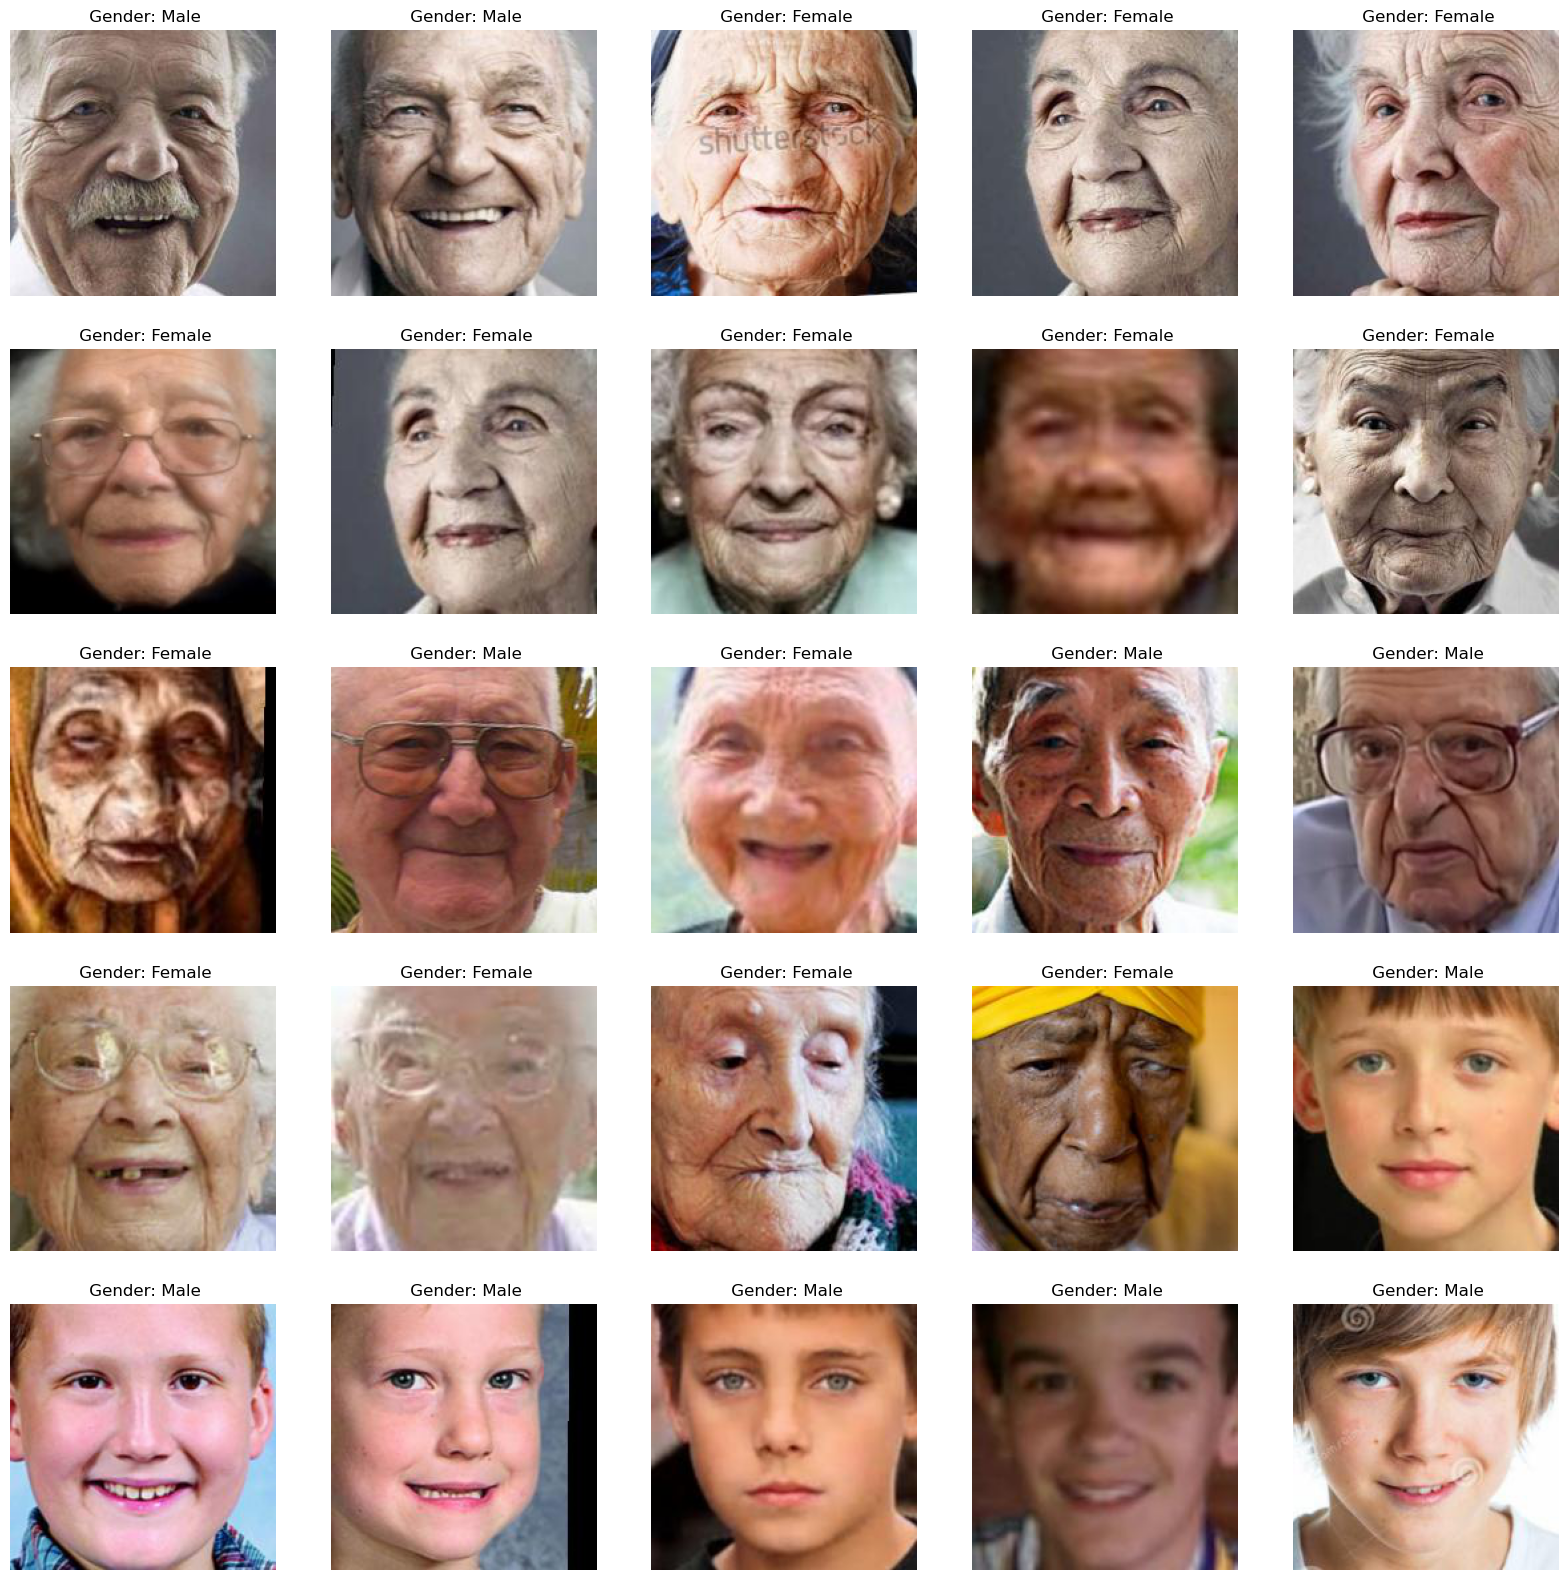

In [ ]:
plt.figure(figsize=(20, 20))                              # Reading the data
files = df.iloc[0:25]

for index, file, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f" Gender: {gender_dict[gender]}")
    plt.axis('off')

In [ ]:
def extract_features(images):                                             # Preprocessing the data
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)

    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X = X/255.0                                 # Normalizing
y_gender = np.array(df['gender'])
input_shape = (128, 128, 1)

In [ ]:
inputs = Input((input_shape))

# Defining the CNN layers

conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(256, activation='relu') (flatten)            # Fully connected layers

dropout_1 = Dropout(0.3) (dense_1)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)

model = Model(inputs=[inputs], outputs=output_1)

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])        # Performance Metrics

In [ ]:
history = model.fit(x=X, y=y_gender, batch_size=32, epochs=50, validation_split=0.2)                # Training

Epoch 1/50
593/593 [==============================] - 181s 305ms/step - loss: 0.2766 - accuracy: 0.8794 - val_loss: 0.4206 - val_accuracy: 0.8165
Epoch 2/50
593/593 [==============================] - 191s 322ms/step - loss: 0.2515 - accuracy: 0.8908 - val_loss: 0.4091 - val_accuracy: 0.8195
Epoch 3/50
593/593 [==============================] - 195s 329ms/step - loss: 0.2272 - accuracy: 0.9037 - val_loss: 0.3915 - val_accuracy: 0.8224
Epoch 4/50
593/593 [==============================] - 178s 300ms/step - loss: 0.2083 - accuracy: 0.9110 - val_loss: 0.4574 - val_accuracy: 0.8129
Epoch 5/50
593/593 [==============================] - 173s 291ms/step - loss: 0.1937 - accuracy: 0.9189 - val_loss: 0.4214 - val_accuracy: 0.8317
Epoch 6/50
593/593 [==============================] - 178s 300ms/step - loss: 0.1801 - accuracy: 0.9252 - val_loss: 0.4453 - val_accuracy: 0.8467
Epoch 7/50
593/593 [==============================] - 181s 305ms/step - loss: 0.1621 - accuracy: 0.9320 - val_loss: 0.4691 -

In [ ]:
# Save trained model weight in h5 file and json file

model_json = model.to_json()
with open("gender2_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights('gender2_model.h5')

In [ ]:
# Defining mappings

emotion_map = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

gender_map = {0:'Male', 1:'Female'}

json_file = open('C:/Users/varun/OneDrive/Desktop/ml project/emotion_model.json', 'r')               # load json and create model
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

json_file = open('C:/Users/varun/OneDrive/Desktop/ml project/gender2_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

emotion_model.load_weights("C:/Users/varun/OneDrive/Desktop/ml project/emotion_model.h5")            # load weights into new model
print("Loaded model")

model.load_weights("C:/Users/varun/OneDrive/Desktop/ml project/gender2_model.h5")
print("Loaded model")

video = cv2.VideoCapture(0)               # Opening the camera feed

face_cap=cv2.CascadeClassifier("C:/Users/varun/OneDrive/Desktop/ml project/haarcascade_frontalface_default.xml")

while True:

    ret, frame = video.read()       # Reading the video frame by frame

    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces available on camera

    faces=face_cap.detectMultiScale(gray_frame,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)

    for (x, y, w, h) in faces:                              # Take each face available on the camera and preprocess it

        new_frame = gray_frame[y:y + h, x:x + w]

        img = cv2.resize(new_frame,(128,128))     # Resize image to match model's expected sizing
        img = img.reshape(1,128,128,1)

        pred = model.predict(img)                              # Predicting gender

        gender = gender_map[round(pred[0][0])]

        resized_img = np.expand_dims(np.expand_dims(cv2.resize(new_frame, (48, 48)), -1), 0)

        emotion_prediction = emotion_model.predict(resized_img)                # Predict the emotions

        emotion = emotion_map[int(np.argmax(emotion_prediction))]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)               # Drawing the boundary box

        # Printing the predictions on the screen for each individual

        cv2.putText(frame, str(gender)+" : "+str(emotion), (x+40, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow('Gender and Emotion Predictor',frame)

    k=cv2.waitKey(1)          # Exit by pressing 'q' key

    if k==ord('q'):
        break

video.release()                 # Closing the camera
cv2.destroyAllWindows()

Loaded model
Loaded model
1/1 [==============================] - 0s 21ms/step
